In [1]:
# Import the Required Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, PReLU, ELU, ReLU, Activation, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.activations import gelu
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.subplots as sp

import warnings

warnings.simplefilter('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# base_dir = os.getcwd()

# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

train_dir = r'C:\Users\USER\Downloads\PROID Model\PROID Model Data\train'
validation_dir = r'C:\Users\USER\Downloads\PROID Model\PROID Model Data\val'
test_dir = r'C:\Users\USER\Downloads\PROID Model\PROID Model Data\test'

In [3]:
def image_gen(batch_size=20):
    
    seed = 42
    img_size = 150
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        seed = seed)
    
    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        seed = seed)

    return train_generator, validation_generator

In [4]:
def image_gen_aug1(batch_size=20):
    
    seed = 42
    img_size = 150
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,  # Randomly rotate images up to 20 degrees
      width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
      height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
      shear_range=0.2,  # Randomly shear images by up to 20%
      zoom_range=0.2,   # Randomly zoom images by up to 20%
      horizontal_flip=True,  # Randomly flip images horizontally
      fill_mode='nearest')  # Specify how to fill in empty pixels during transformations
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        seed=seed
    )
    
    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        seed = seed)

    return train_generator, validation_generator

In [5]:
def plot_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(epochs, acc, 'bo', label='Training Accuracy')
    ax1.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(epochs, loss, 'bo', label='Training Loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def param_plot(histories):
    fig, axes = plt.subplots(2, 2, figsize=(18, 20))
    ax1, ax2, ax3, ax4 = axes.flatten()
    
    markers = ['o', 's', '+', '*']
    for i, param1 in enumerate(histories):
        marker = markers[i % len(markers)]
        ax1.plot(histories[param1]['acc'], label=param1, marker=marker)
    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    for i, param2 in enumerate(histories):
        marker = markers[i % len(markers)]
        ax2.plot(histories[param2]['val_acc'], label=param2, marker=marker)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Loss
    for i, param3 in enumerate(histories):
        marker = markers[i % len(markers)]
        ax3.plot(histories[param3]['loss'], label=param3, marker=marker)
    ax3.set_title('Training Loss')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.legend()

    for i, param4 in enumerate(histories):
        marker = markers[i % len(markers)]
        ax4.plot(histories[param4]['val_loss'], label=param4, marker=marker)
    ax4.set_title('Validation Loss')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Loss')
    ax4.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def image_process(img):
    img_size = 150
    image = load_img(img, target_size=(img_size, img_size))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Prediction function
def prediction(model, img_array, items_l):
    prob = model.predict(img_array)
    if prob.shape[1] == 1:
        prob = np.array([[1 - prob[0][0], prob[0][0]]])  # Adjusted for binary classification

    prob_reshaped = prob.reshape(1, -1)

    prob_df = pd.DataFrame(prob_reshaped, columns=items_l)
    result = items_l[np.argmax(prob_reshaped, axis=1)[0]]  # Correctly indexing the list

    return prob_df, result

### Baseline Model

In [30]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
train_generator, validation_generator = image_gen(batch_size=32)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [32]:
history = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - acc: 0.6654 - loss: 0.6179 - val_acc: 0.8260 - val_loss: 0.4147
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - acc: 0.7374 - loss: 0.5338 - val_acc: 0.8200 - val_loss: 0.4053
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - acc: 0.7597 - loss: 0.4967 - val_acc: 0.8620 - val_loss: 0.3942
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - acc: 0.7679 - loss: 0.4796 - val_acc: 0.8440 - val_loss: 0.3742
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - acc: 0.7619 - loss: 0.4820 - val_acc: 0.8500 - val_loss: 0.4152
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - acc: 0.7752 - loss: 0.4845 - val_acc: 0.8300 - val_loss: 0.4031
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - acc: 0.7930 - loss: 0.4392 - val_acc: 0.8080 - val_loss: 0.4218
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - acc: 0.8032 - loss: 0.4042 - val_acc: 0.7780 - val_loss: 0.5288
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step 

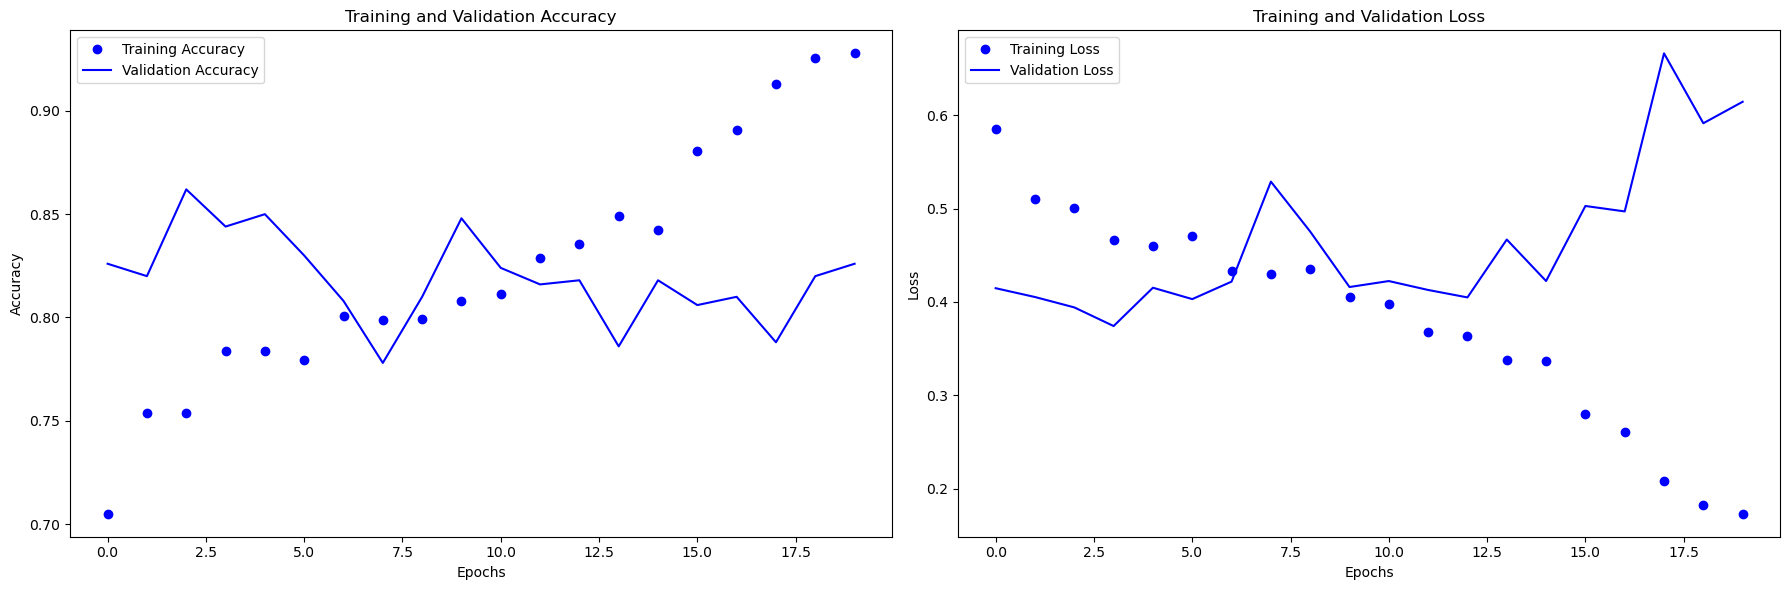

In [33]:
plot_graph(history)

Significant val drop for 5th epoch, overfitting. Augmentation to sustain val increase.

### Image Augmentation

In [34]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=20,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - acc: 0.5916 - loss: 0.6782 - val_acc: 0.8140 - val_loss: 0.4165
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - acc: 0.7371 - loss: 0.5282 - val_acc: 0.8420 - val_loss: 0.3906
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - acc: 0.7423 - loss: 0.5193 - val_acc: 0.8380 - val_loss: 0.3931
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7780 - loss: 0.4753 - val_acc: 0.8260 - val_loss: 0.3920
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - acc: 0.7646 - loss: 0.4666 - val_acc: 0.8340 - val_loss: 0.4060
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - acc: 0.8025 - loss: 0.4300 - val_acc: 0.8140 - val_loss: 0.4274
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - acc: 0.7978 - loss: 0.4426 - val_acc: 0.7080 - val_loss: 0.5433
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - acc: 0.7491 - loss: 0.4827 - 

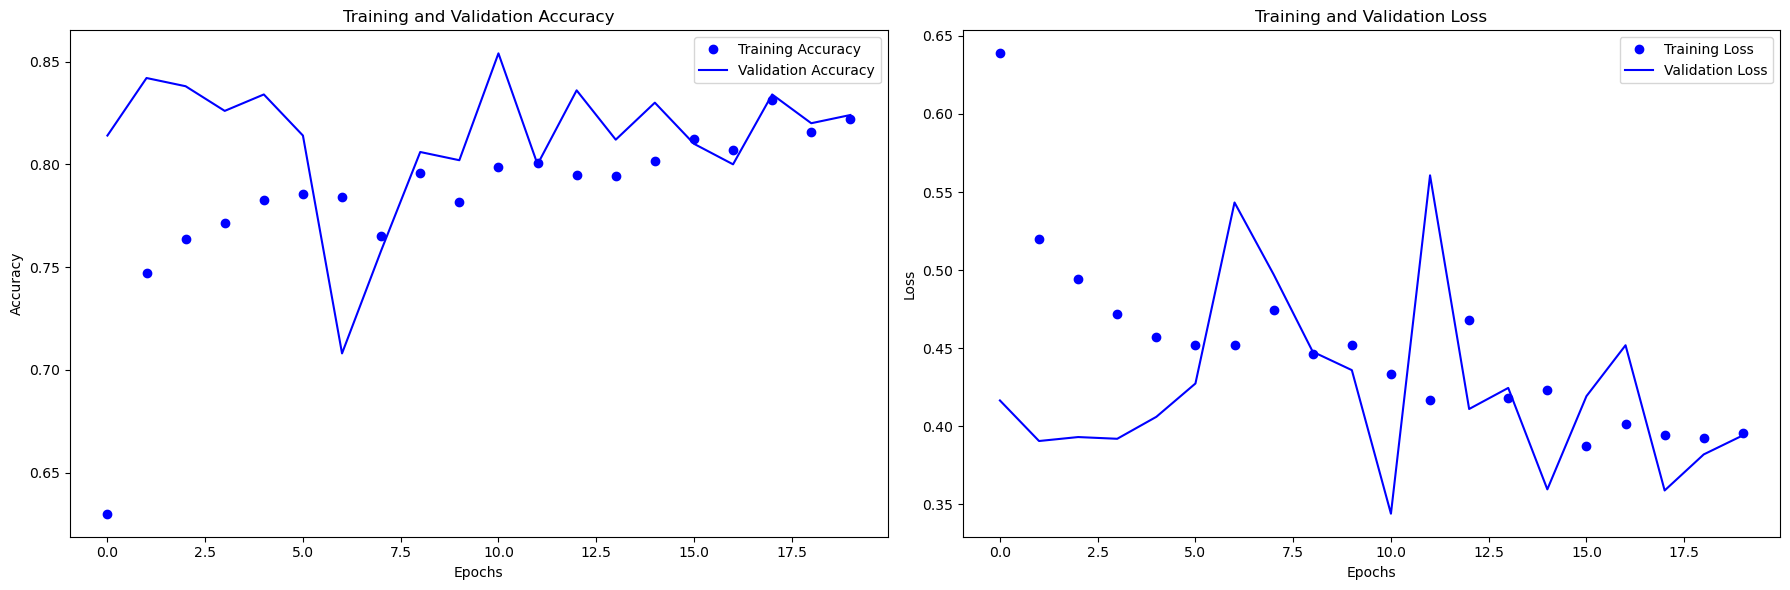

In [35]:
plot_graph(history)

### Optimizer

In [10]:
hyperparameter_name= 'Optimizer'
params = {hyperparameter_name: [optimizers.Adam, optimizers.RMSprop, optimizers.SGD, optimizers.Adagrad, optimizers.Adadelta]}
optimizer_name = ['Adam', 'RMSprop', 'SGD', 'Adagrad', 'Adadelta']

i = 0
histories= {}
for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)
    
    img_size = 150

    model = models.Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(loss='binary_crossentropy',
                optimizer=value(learning_rate=0.001),
                metrics=['acc'])

    train_generator, validation_generator = image_gen_aug1()
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)
    
    print('\n')

    histories[hyperparameter_name+' '+optimizer_name[i]] = history.history
    i += 1

Optimizer <class 'keras.src.optimizers.adam.Adam'>


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - acc: 0.5958 - loss: 0.6496 - val_acc: 0.7880 - val_loss: 0.4463
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - acc: 0.7320 - loss: 0.5215 - val_acc: 0.8360 - val_loss: 0.3895
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - acc: 0.7716 - loss: 0.4906 - val_acc: 0.8420 - val_loss: 0.3933
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - acc: 0.7699 - loss: 0.4840 - val_acc: 0.8440 - val_loss: 0.4185
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - acc: 0.7992 - loss: 0.4596 - val_acc: 0.8460 - val_loss: 0.4144
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - acc: 0.7811 - loss: 0.4648 - val_acc: 0.8580 - val_loss: 0.3551
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - acc: 0.7926 - loss: 0.4497 - val_acc: 0.8440 - val_loss: 0.3684
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - acc: 0.8108 - loss: 0.4276 - 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - acc: 0.6159 - loss: 0.6586 - val_acc: 0.8360 - val_loss: 0.4824
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - acc: 0.7388 - loss: 0.5616 - val_acc: 0.8340 - val_loss: 0.3889
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - acc: 0.7323 - loss: 0.5295 - val_acc: 0.8560 - val_loss: 0.3807
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - acc: 0.7681 - loss: 0.4989 - val_acc: 0.8700 - val_loss: 0.3719
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - acc: 0.7777 - loss: 0.4841 - val_acc: 0.8640 - val_loss: 0.3750
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - acc: 0.7887 - loss: 0.4431 - val_acc: 0.8120 - val_loss: 0.4292
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - acc: 0.7954 - loss: 0.4401 - val_acc: 0.8400 - val_loss: 0.3751
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - acc: 0.7926 - loss: 0.4426 - 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - acc: 0.4820 - loss: 0.6936 - val_acc: 0.7280 - val_loss: 0.6899
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - acc: 0.7038 - loss: 0.6903 - val_acc: 0.6520 - val_loss: 0.6860
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - acc: 0.6038 - loss: 0.6876 - val_acc: 0.6460 - val_loss: 0.6824
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - acc: 0.5950 - loss: 0.6842 - val_acc: 0.6660 - val_loss: 0.6786
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - acc: 0.5968 - loss: 0.6835 - val_acc: 0.6700 - val_loss: 0.6749
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - acc: 0.6165 - loss: 0.6799 - val_acc: 0.6980 - val_loss: 0.6710
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - acc: 0.6488 - loss: 0.6764 - val_acc: 0.7440 - val_loss: 0.6671
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - acc: 0.6569 - loss: 0.6746 - 

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - acc: 0.5333 - loss: 0.6891 - val_acc: 0.5000 - val_loss: 0.6806
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - acc: 0.5268 - loss: 0.6844 - val_acc: 0.5120 - val_loss: 0.6717
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - acc: 0.5555 - loss: 0.6744 - val_acc: 0.5620 - val_loss: 0.6613
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - acc: 0.5743 - loss: 0.6693 - val_acc: 0.7160 - val_loss: 0.6493
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - acc: 0.6510 - loss: 0.6603 - val_acc: 0.7660 - val_loss: 0.6307
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - acc: 0.6811 - loss: 0.6442 - val_acc: 0.8160 - val_loss: 0.6103
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - acc: 0.7124 - loss: 0.6366 - val_acc: 0.8020 - val_loss: 0.5775
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - acc: 0.7297 - loss: 0.6173 - 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - acc: 0.5534 - loss: 0.6877 - val_acc: 0.5000 - val_loss: 0.6906
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - acc: 0.5279 - loss: 0.6912 - val_acc: 0.5000 - val_loss: 0.6889
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - acc: 0.5490 - loss: 0.6871 - val_acc: 0.5000 - val_loss: 0.6874
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - acc: 0.5395 - loss: 0.6878 - val_acc: 0.5000 - val_loss: 0.6862
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - acc: 0.5319 - loss: 0.6883 - val_acc: 0.5000 - val_loss: 0.6850
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - acc: 0.5279 - loss: 0.6877 - val_acc: 0.5000 - val_loss: 0.6839
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - acc: 0.5283 - loss: 0.6868 - val_acc: 0.5000 - val_loss: 0.6827
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - acc: 0.5471 - loss: 0.6833 - 

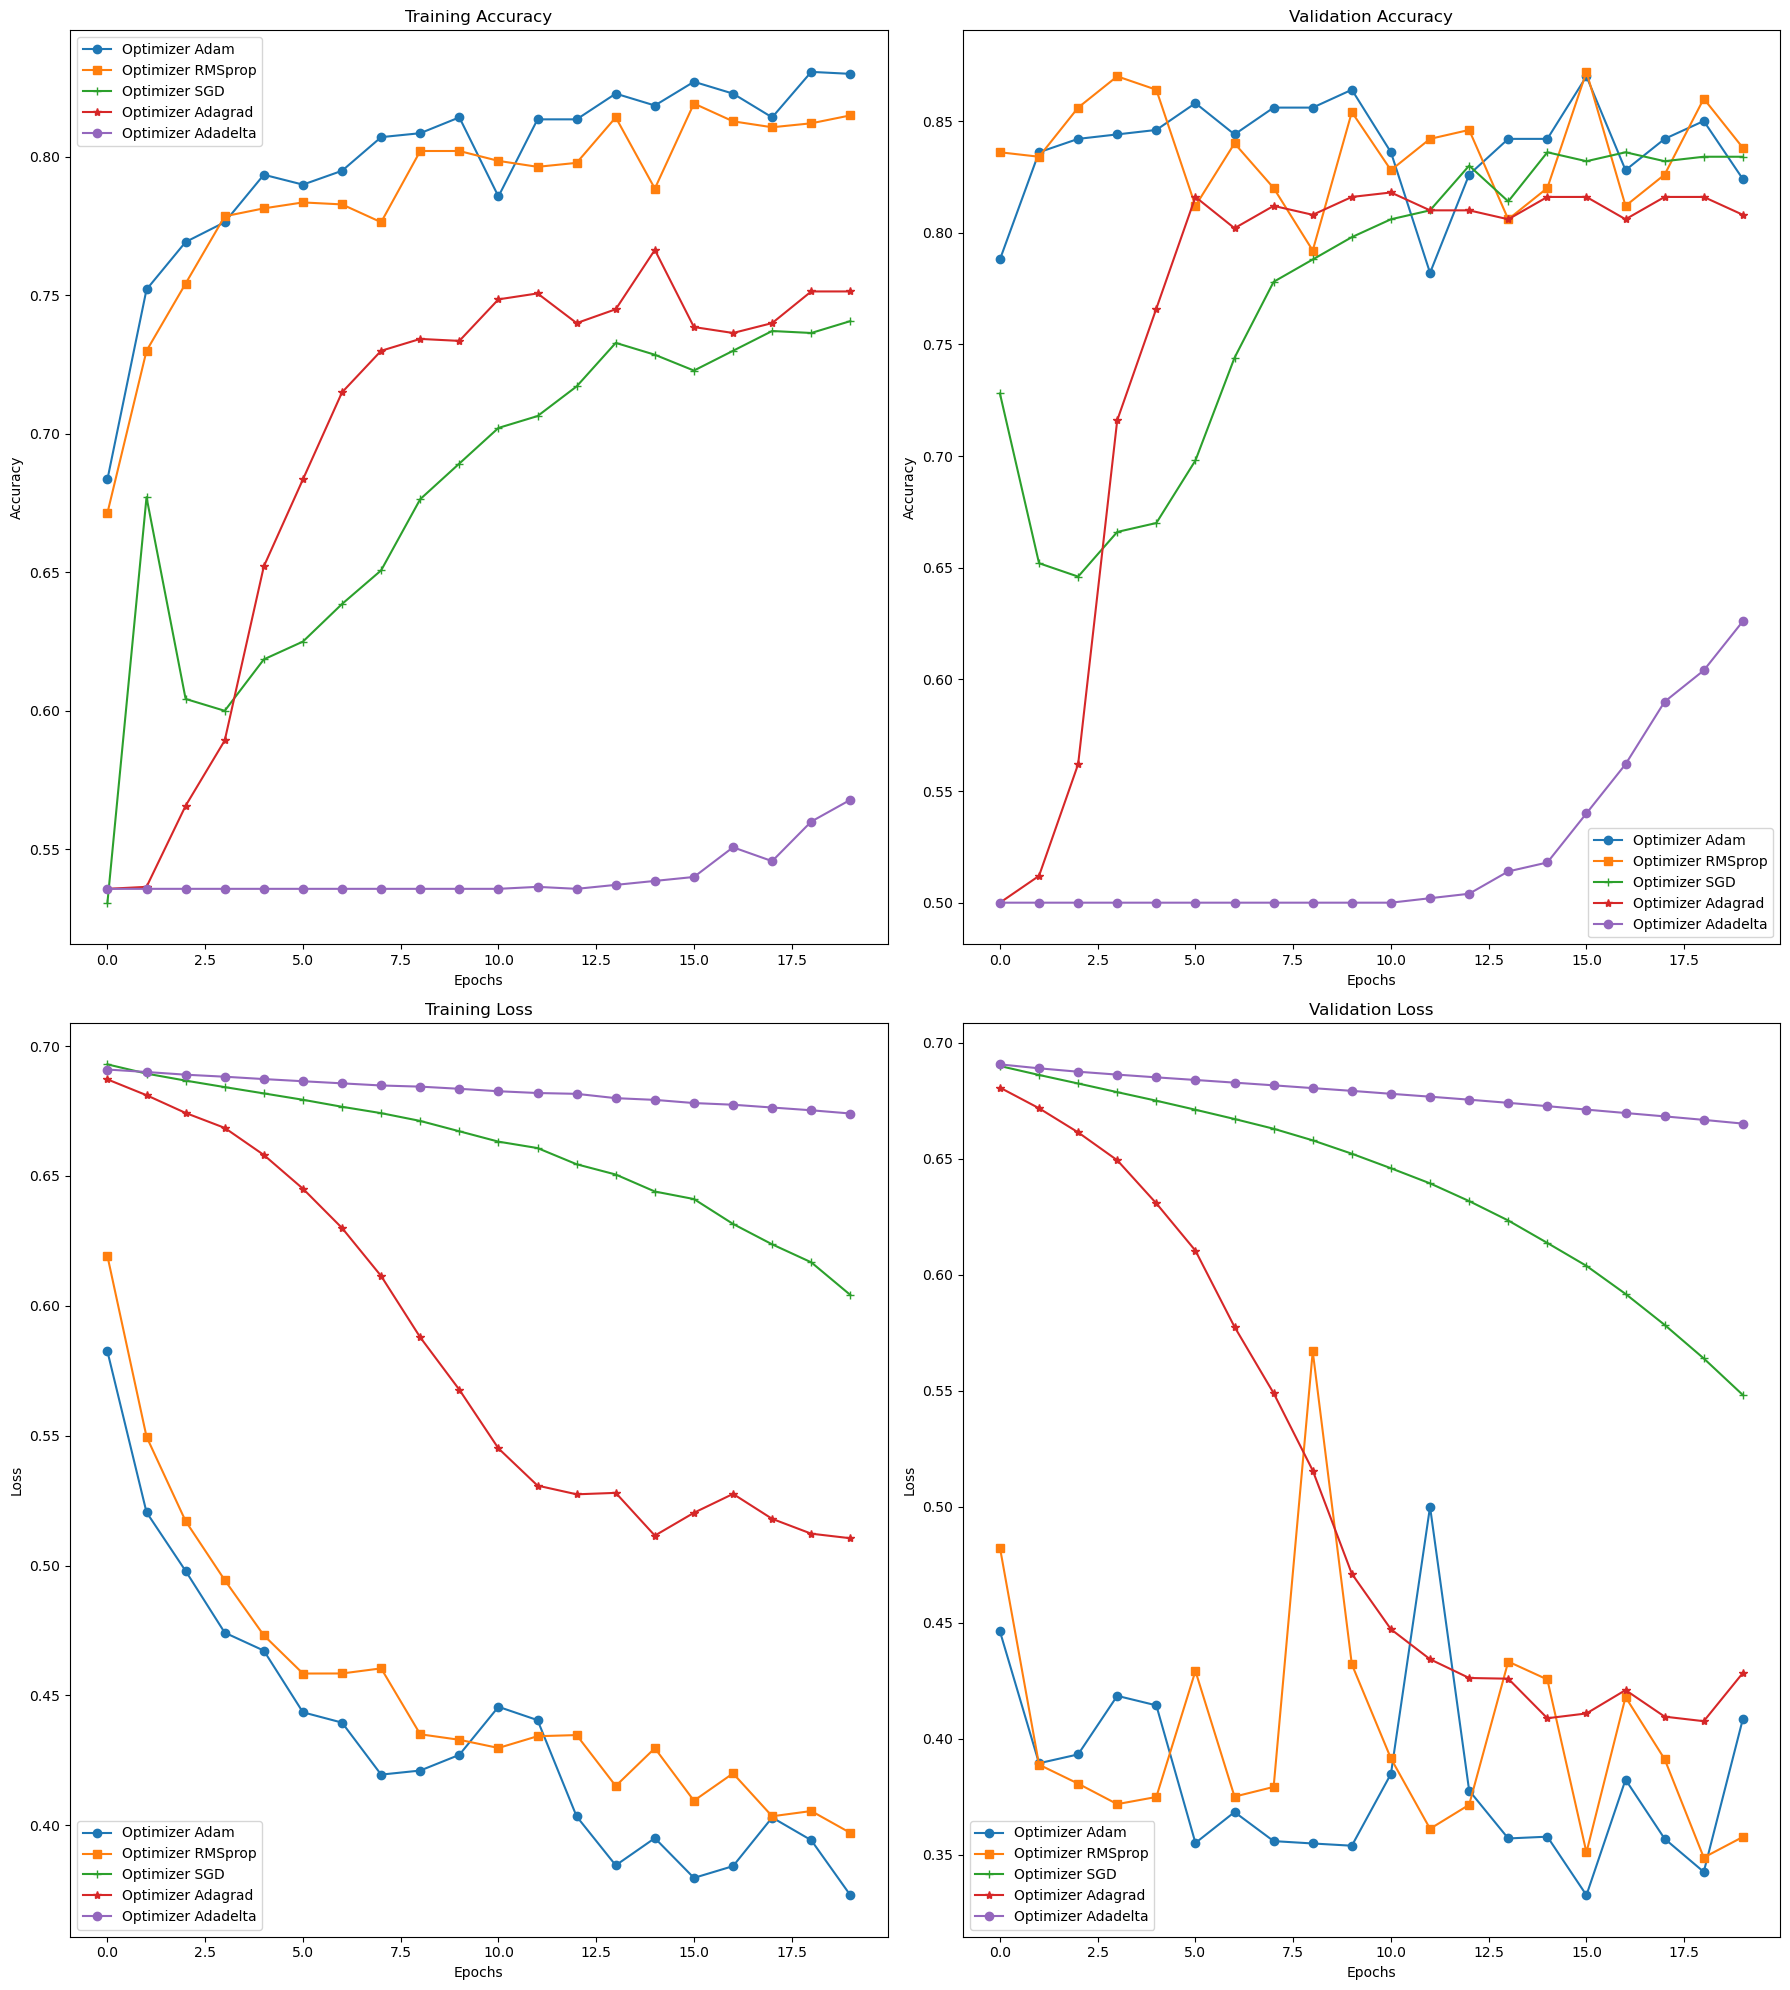

In [11]:
param_plot(histories)

### Batch Size

In [13]:
hyperparameter_name= 'Batch_Size'
params = {hyperparameter_name: [15, 20, 32, 64, 128]}

histories2= {}
for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)
    
    img_size = 150
    
    model = models.Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    train_generator, validation_generator = image_gen_aug1(batch_size=value)
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)
    
    print('\n')

    histories2[hyperparameter_name+' '+str(value)] = history.history

Batch_Size 15


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - acc: 0.6266 - loss: 0.6634 - val_acc: 0.8360 - val_loss: 0.4429
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - acc: 0.7372 - loss: 0.5528 - val_acc: 0.7700 - val_loss: 0.5591
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - acc: 0.7440 - loss: 0.5177 - val_acc: 0.8020 - val_loss: 0.4646
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - acc: 0.7377 - loss: 0.5272 - val_acc: 0.8080 - val_loss: 0.4704
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - acc: 0.7768 - loss: 0.4673 - val_acc: 0.8360 - val_loss: 0.4162
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - acc: 0.7755 - loss: 0.4586 - val_acc: 0.8240 - val_loss: 0.4085
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - acc: 0.7914 - loss: 0.4373 - val_acc: 0.8400 - val_loss: 0.3888
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - acc: 0.7760 - loss: 0.4462 - 

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_62 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - acc: 0.6624 - loss: 0.6100 - val_acc: 0.8480 - val_loss: 0.4242
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - acc: 0.7315 - loss: 0.5407 - val_acc: 0.8360 - val_loss: 0.4589
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - acc: 0.7571 - loss: 0.5112 - val_acc: 0.7780 - val_loss: 0.5342
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - acc: 0.7749 - loss: 0.4879 - val_acc: 0.7820 - val_loss: 0.5519
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - acc: 0.7797 - loss: 0.4710 - val_acc: 0.7440 - val_loss: 0.7429
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - acc: 0.7738 - loss: 0.4709 - val_acc: 0.7780 - val_loss: 0.5601
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - acc: 0.7777 - loss: 0.4798 - val_acc: 0.7380 - val_loss: 0.5505
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - acc: 0.7871 - loss: 0.4312 - 

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - acc: 0.6239 - loss: 0.6729 - val_acc: 0.8200 - val_loss: 0.4845
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - acc: 0.7583 - loss: 0.5410 - val_acc: 0.7840 - val_loss: 0.4964
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7530 - loss: 0.5056 - val_acc: 0.8220 - val_loss: 0.4260
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - acc: 0.7616 - loss: 0.4948 - val_acc: 0.8480 - val_loss: 0.3886
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - acc: 0.7556 - loss: 0.4920 - val_acc: 0.8160 - val_loss: 0.4660
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - acc: 0.7501 - loss: 0.4967 - val_acc: 0.7960 - val_loss: 0.4542
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - acc: 0.7923 - loss: 0.4568 - val_acc: 0.7960 - val_loss: 0.4971
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - acc: 0.8121 - loss: 0.4070 - 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_71 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 622ms/step - acc: 0.5805 - loss: 0.6622 - val_acc: 0.8480 - val_loss: 0.4467
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 640ms/step - acc: 0.7285 - loss: 0.5534 - val_acc: 0.8600 - val_loss: 0.4360
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 529ms/step - acc: 0.7473 - loss: 0.5525 - val_acc: 0.7740 - val_loss: 0.4959
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step - acc: 0.7718 - loss: 0.5022 - val_acc: 0.7900 - val_loss: 0.4621
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 512ms/step - acc: 0.7683 - loss: 0.4949 - val_acc: 0.8440 - val_loss: 0.3966
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 552ms/step - acc: 0.7651 - loss: 0.4917 - val_acc: 0.8120 - val_loss: 0.4541
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 528ms/step - acc: 0.7978 - loss: 0.4337 - val_acc: 0.8120 - val_loss: 0.4314
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step - acc: 0.7695 - loss: 0.4825 - 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 918ms/step - acc: 0.5199 - loss: 0.6842 - val_acc: 0.7920 - val_loss: 0.5164
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 755ms/step - acc: 0.7347 - loss: 0.5413 - val_acc: 0.7720 - val_loss: 0.5063
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 707ms/step - acc: 0.7532 - loss: 0.5367 - val_acc: 0.7860 - val_loss: 0.4931
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 737ms/step - acc: 0.7522 - loss: 0.5368 - val_acc: 0.7700 - val_loss: 0.4797
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 842ms/step - acc: 0.7699 - loss: 0.4971 - val_acc: 0.8640 - val_loss: 0.3622
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 836ms/step - acc: 0.7755 - loss: 0.4782 - val_acc: 0.8140 - val_loss: 0.4299
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - acc: 0.7722 - loss: 0.4583 - val_acc: 0.8480 - val_loss: 0.3749
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 760ms/step - acc: 0.7893 - loss: 0.4388 - 

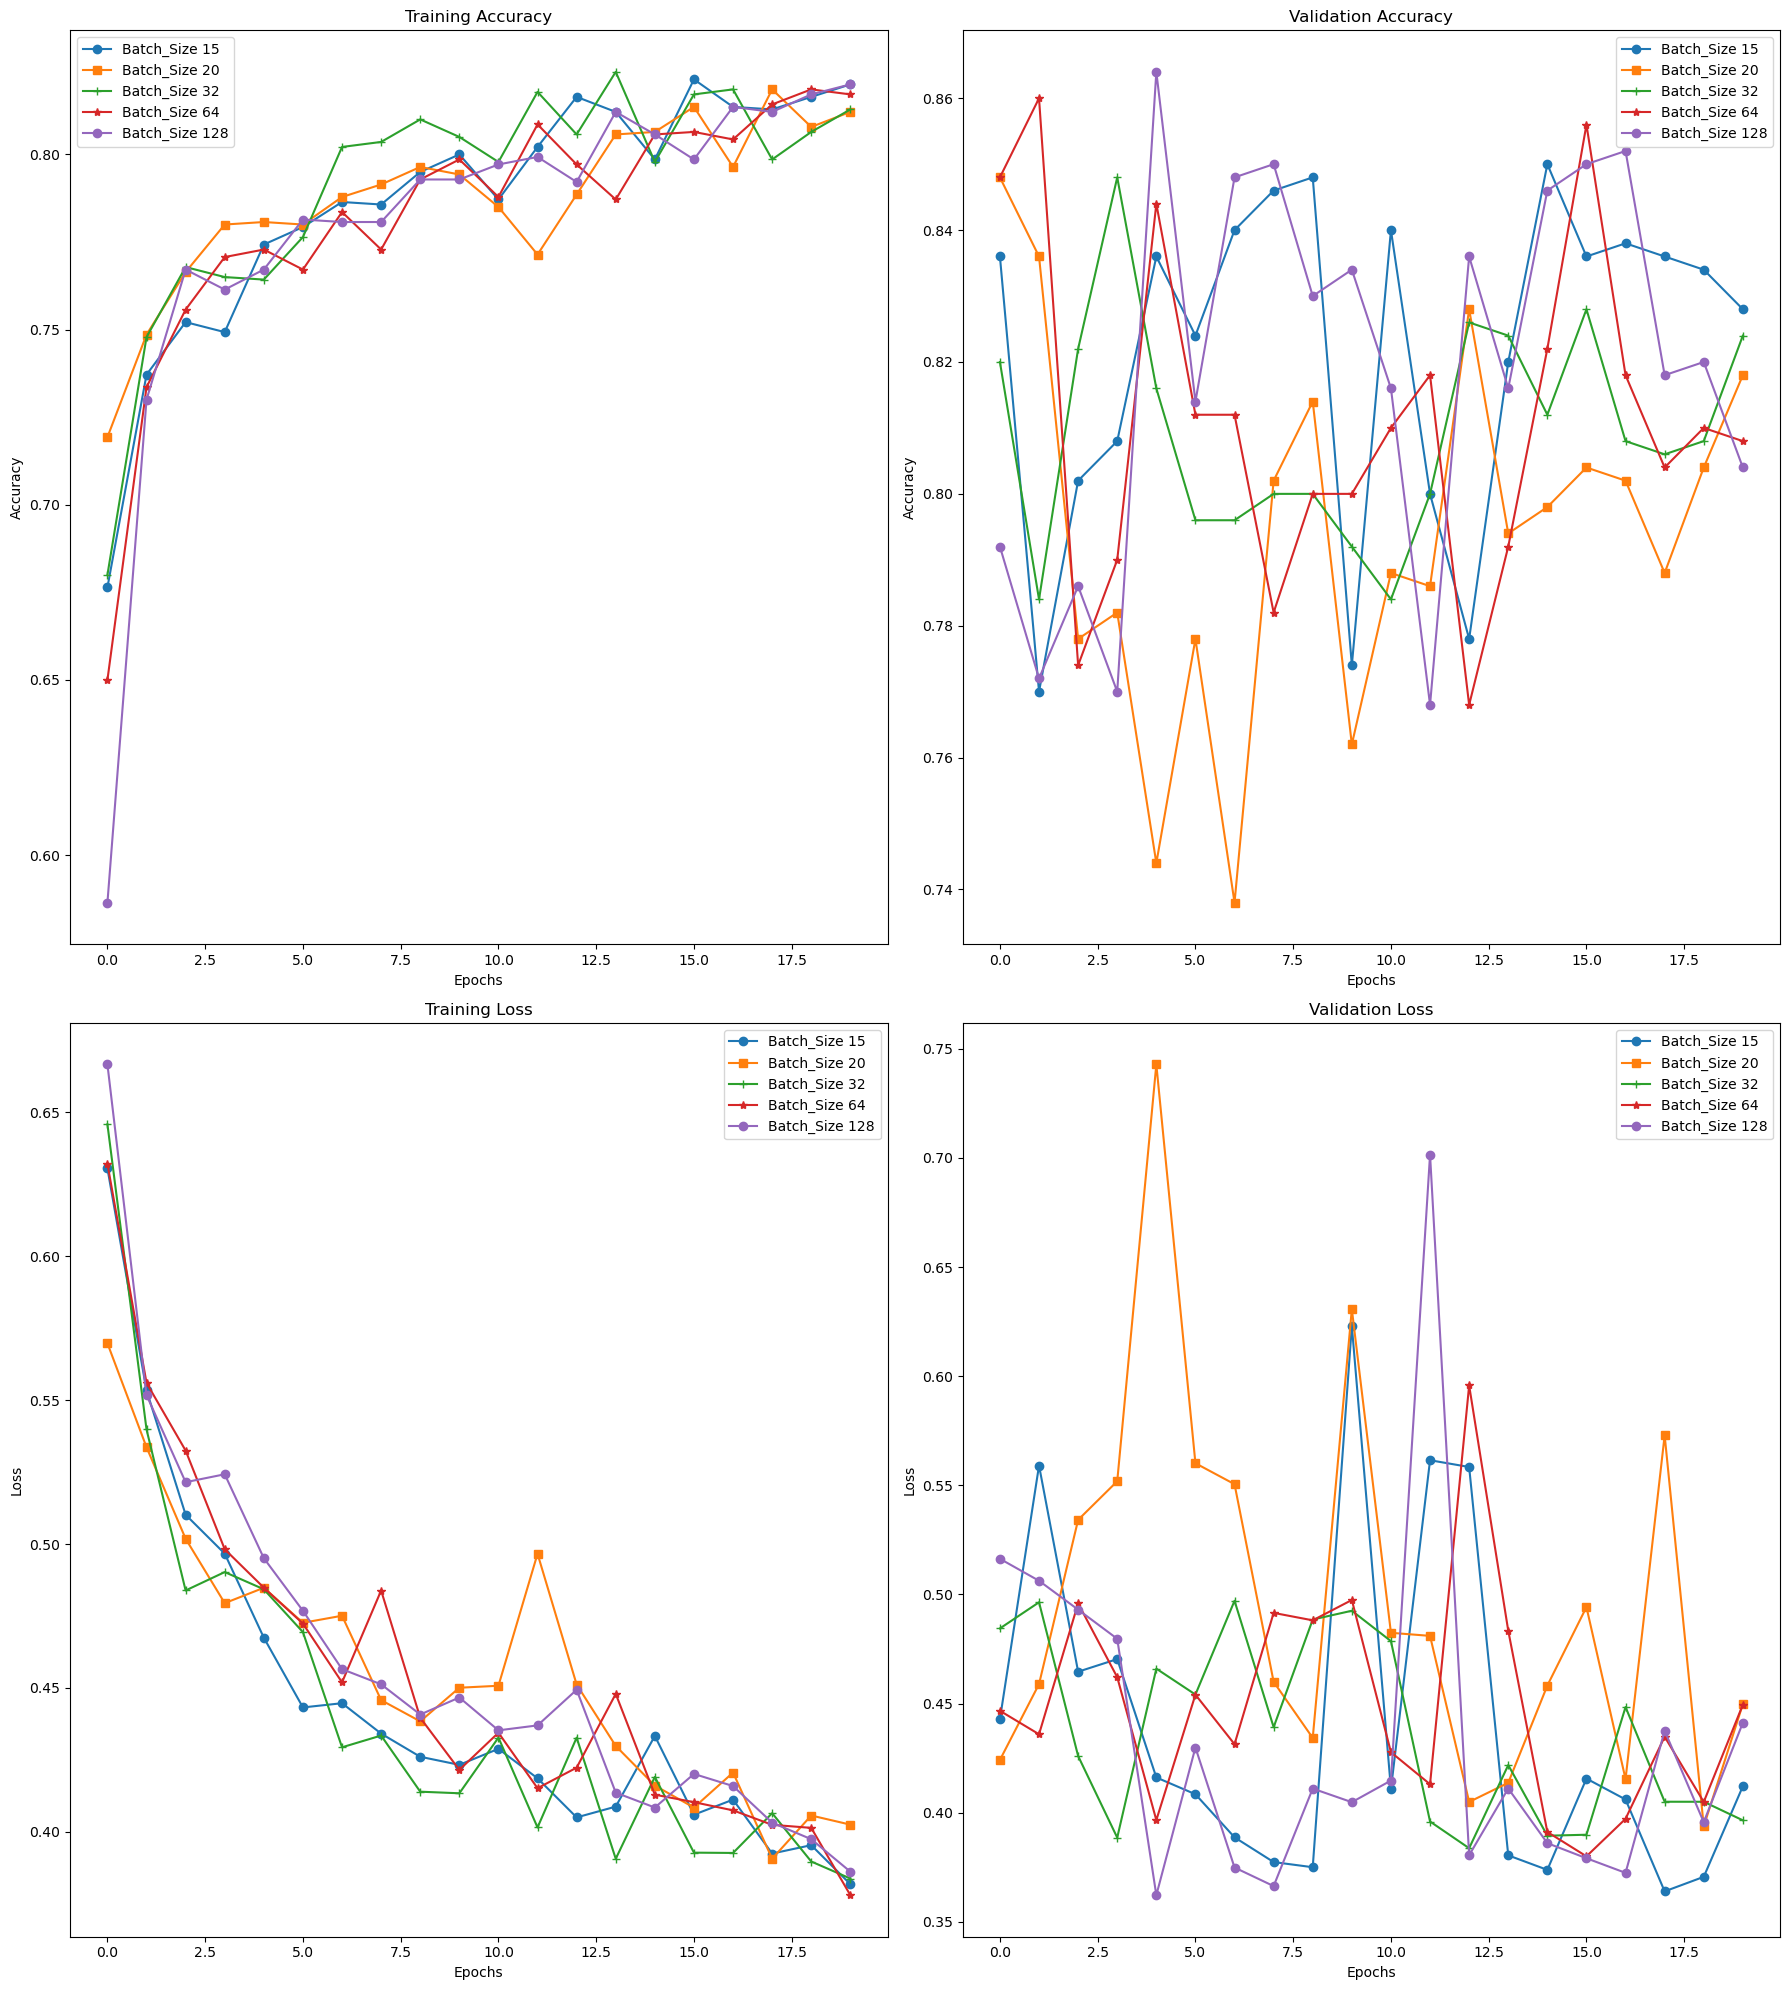

In [14]:
param_plot(histories2)

### Learning Rate

In [16]:
hyperparameter_name= 'Learning_Rate'
params = {hyperparameter_name: [0.00001, 0.0001, 0.001, 0.01, 0.1]}

histories3= {}
for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)
    
    img_size = 150

    model = models.Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=value),
                metrics=['acc'])

    train_generator, validation_generator = image_gen_aug1(batch_size=32)
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)
    
    print('\n')

    histories3[hyperparameter_name+' '+str(value)] = history.history

Learning_Rate 1e-05


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_86 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_87 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_88 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - acc: 0.5337 - loss: 0.6926 - val_acc: 0.5460 - val_loss: 0.6887
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - acc: 0.5675 - loss: 0.6890 - val_acc: 0.6480 - val_loss: 0.6823
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - acc: 0.6474 - loss: 0.6841 - val_acc: 0.7780 - val_loss: 0.6712
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - acc: 0.7227 - loss: 0.6766 - val_acc: 0.8520 - val_loss: 0.6537
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - acc: 0.7436 - loss: 0.6627 - val_acc: 0.8560 - val_loss: 0.6271
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - acc: 0.7635 - loss: 0.6418 - val_acc: 0.8320 - val_loss: 0.5913
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - acc: 0.7581 - loss: 0.6127 - val_acc: 0.8300 - val_loss: 0.5384
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - acc: 0.7482 - loss: 0.5849 - 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_90 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_91 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_92 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_93 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 294ms/step - acc: 0.5936 - loss: 0.6777 - val_acc: 0.7700 - val_loss: 0.5581
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - acc: 0.7622 - loss: 0.5420 - val_acc: 0.7940 - val_loss: 0.4387
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - acc: 0.7680 - loss: 0.4849 - val_acc: 0.7840 - val_loss: 0.4736
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - acc: 0.7611 - loss: 0.5019 - val_acc: 0.7940 - val_loss: 0.4553
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - acc: 0.7283 - loss: 0.5355 - val_acc: 0.8240 - val_loss: 0.3899
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - acc: 0.7557 - loss: 0.4959 - val_acc: 0.8020 - val_loss: 0.4190
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - acc: 0.7853 - loss: 0.4637 - val_acc: 0.8540 - val_loss: 0.3612
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - acc: 0.7588 - loss: 0.4734 - 

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_96 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_97 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_98 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_99 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 291ms/step - acc: 0.6114 - loss: 0.6527 - val_acc: 0.7760 - val_loss: 0.4630
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - acc: 0.7652 - loss: 0.4978 - val_acc: 0.8400 - val_loss: 0.4198
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - acc: 0.7596 - loss: 0.4740 - val_acc: 0.8300 - val_loss: 0.3896
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - acc: 0.7903 - loss: 0.4593 - val_acc: 0.8500 - val_loss: 0.3983
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - acc: 0.7723 - loss: 0.4640 - val_acc: 0.8340 - val_loss: 0.4225
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - acc: 0.8103 - loss: 0.4128 - val_acc: 0.8060 - val_loss: 0.4277
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - acc: 0.7949 - loss: 0.4440 - val_acc: 0.8400 - val_loss: 0.3951
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - acc: 0.7815 - loss: 0.4467 - 

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_100 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_101 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_102 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_103 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_104 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - acc: 0.5349 - loss: 0.8593 - val_acc: 0.7960 - val_loss: 0.6565
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - acc: 0.5929 - loss: 0.6903 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - acc: 0.5262 - loss: 0.6920 - val_acc: 0.5000 - val_loss: 0.6970
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - acc: 0.5365 - loss: 0.6908 - val_acc: 0.5000 - val_loss: 0.6959
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - acc: 0.5402 - loss: 0.6901 - val_acc: 0.5000 - val_loss: 0.6950
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - acc: 0.5365 - loss: 0.6907 - val_acc: 0.5000 - val_loss: 0.6958
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - acc: 0.5384 - loss: 0.6905 - val_acc: 0.5000 - val_loss: 0.6968
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - acc: 0.5342 - loss: 0.6911 - 

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_105 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_106 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_107 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_109 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - acc: 0.5180 - loss: 57384.0273 - val_acc: 0.5000 - val_loss: 0.9852
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - acc: 0.4908 - loss: 0.9075 - val_acc: 0.5000 - val_loss: 0.6996
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - acc: 0.4989 - loss: 0.7522 - val_acc: 0.5000 - val_loss: 0.7732
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - acc: 0.5012 - loss: 0.7644 - val_acc: 0.5000 - val_loss: 0.6943
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - acc: 0.4955 - loss: 0.7069 - val_acc: 0.5000 - val_loss: 0.7130
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - acc: 0.5181 - loss: 0.7061 - val_acc: 0.5000 - val_loss: 0.6976
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - acc: 0.5566 - loss: 0.6899 - val_acc: 0.5000 - val_loss: 0.6964
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - acc: 0.4799 - loss: 0.702

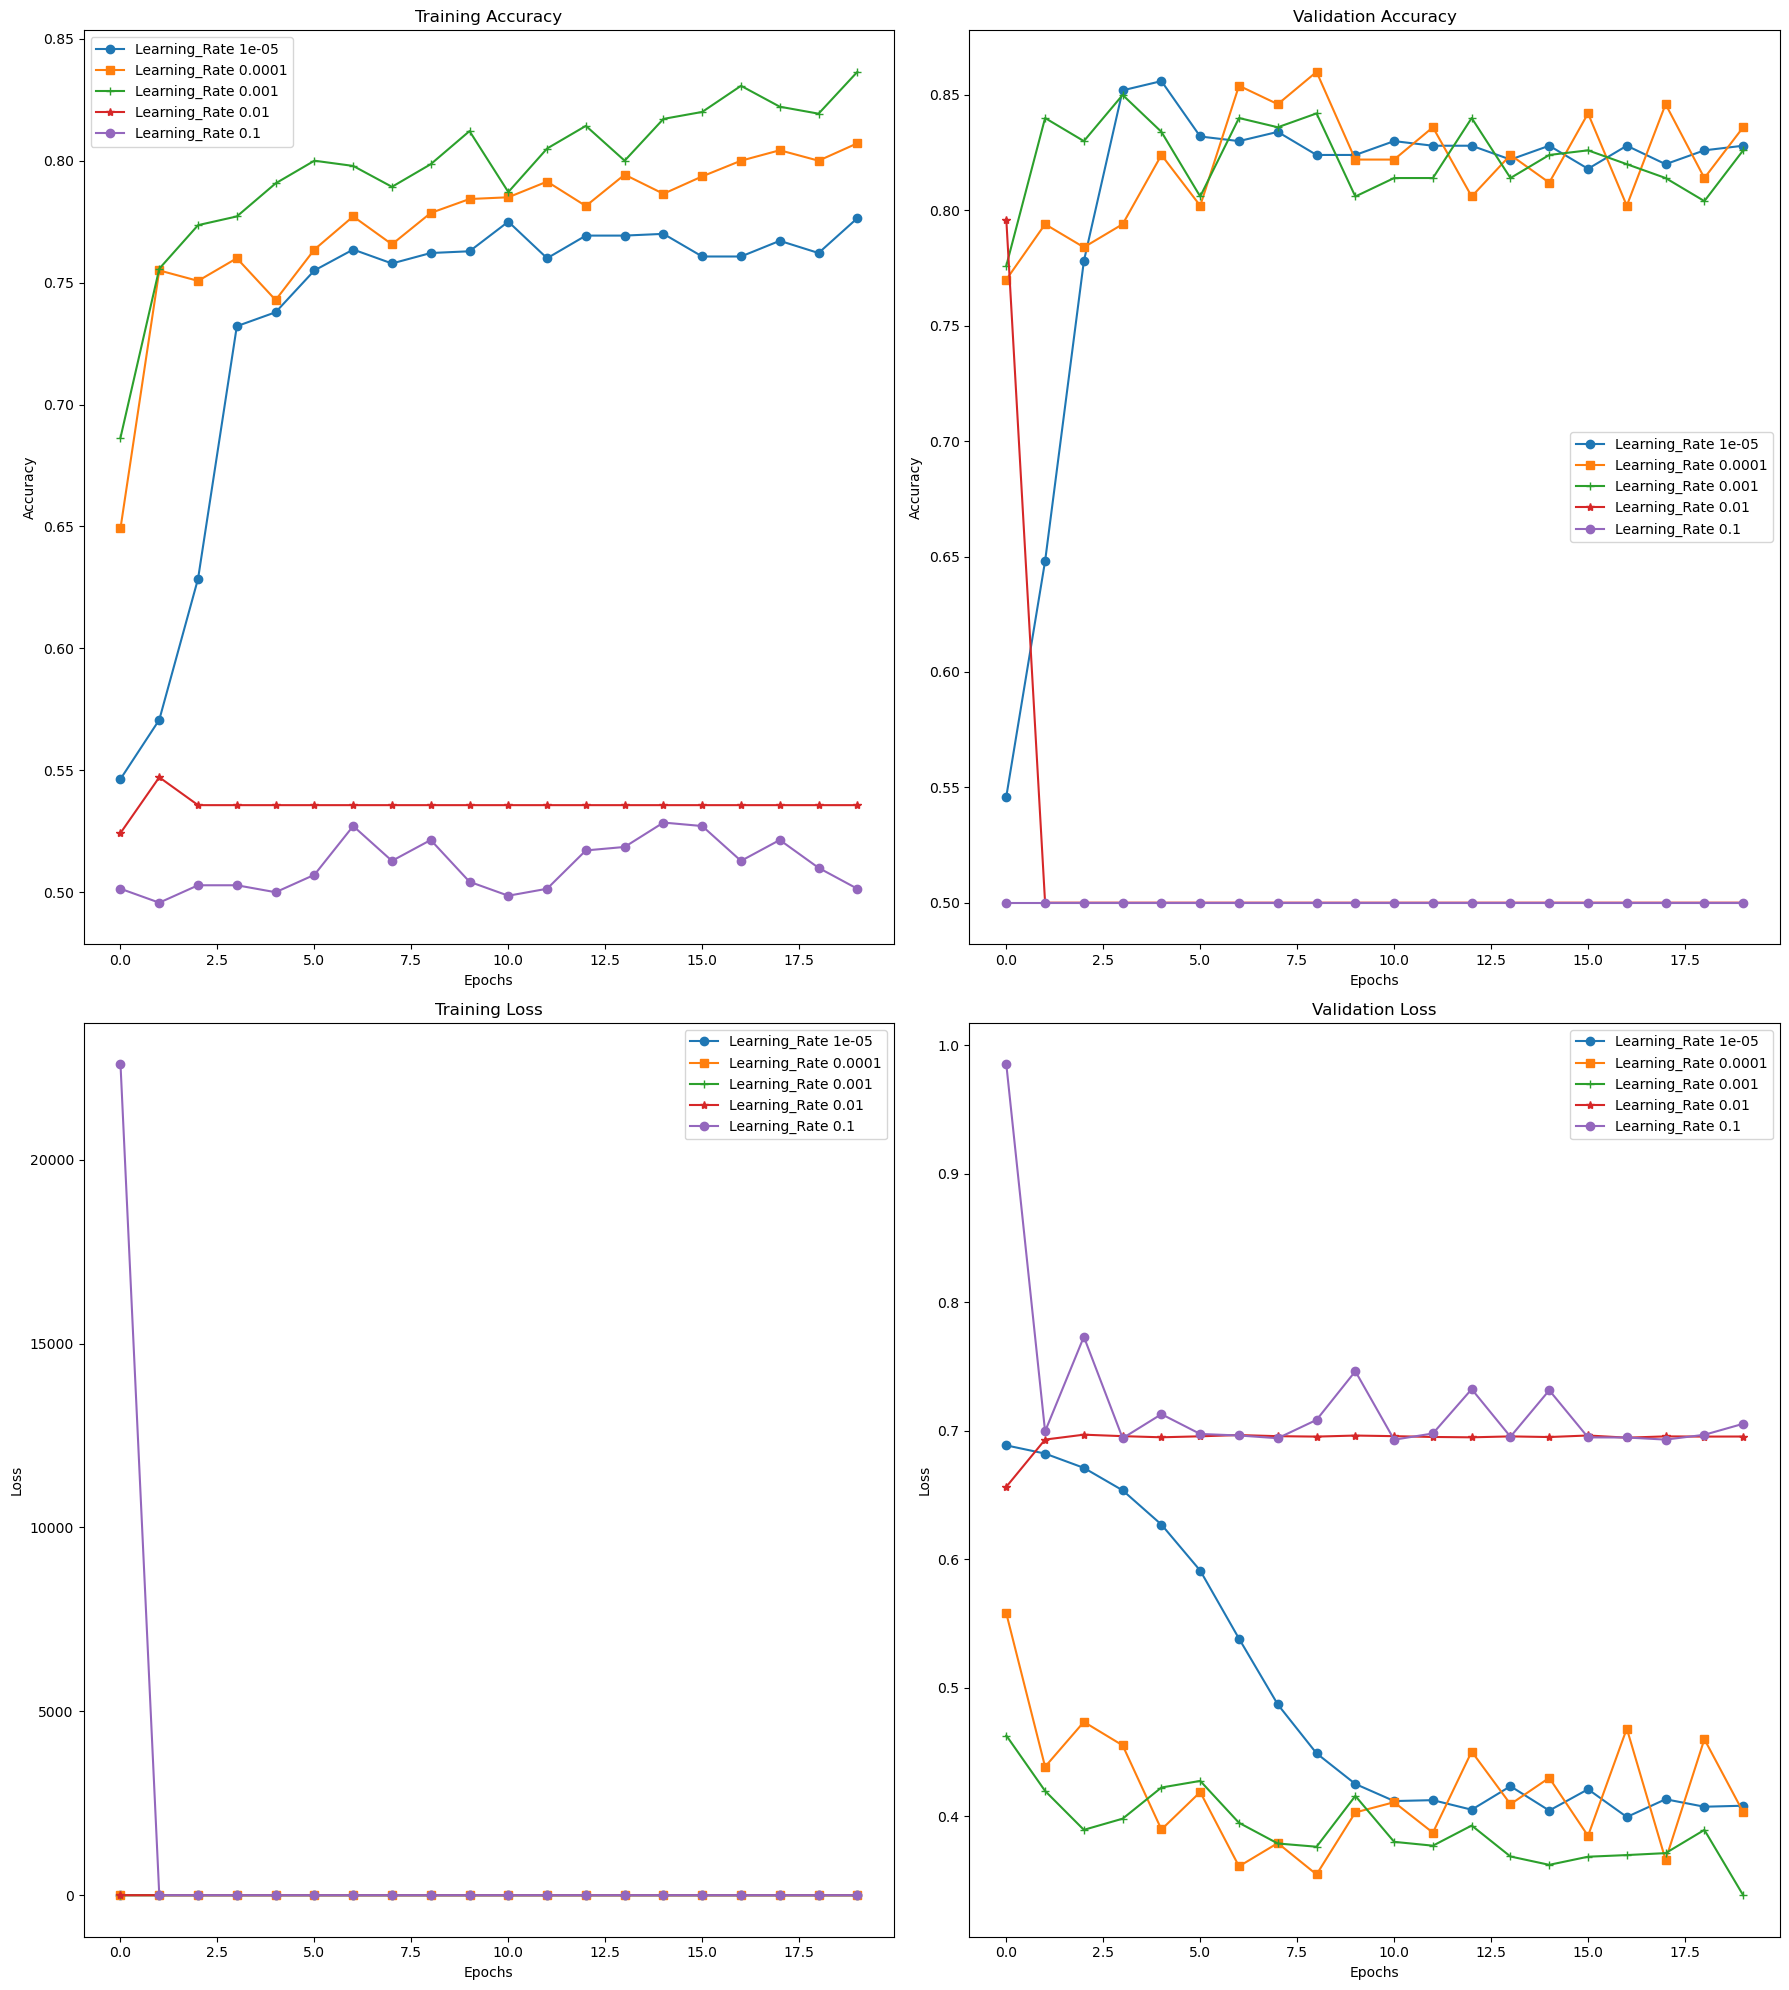

In [17]:
param_plot(histories3)

In [18]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=20,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_111 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_110 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_111 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_112 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_113 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_115 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_114 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,817 (1.19 MB)

 Trainable params: 310,817 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 541ms/step - acc: 0.5806 - loss: 0.6740 - val_acc: 0.8360 - val_loss: 0.5272
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - acc: 0.7479 - loss: 0.5562 - val_acc: 0.7920 - val_loss: 0.4483
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - acc: 0.7794 - loss: 0.4793 - val_acc: 0.7940 - val_loss: 0.4446
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - acc: 0.7669 - loss: 0.4864 - val_acc: 0.8380 - val_loss: 0.3805
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - acc: 0.7725 - loss: 0.4713 - val_acc: 0.8020 - val_loss: 0.4370
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - acc: 0.7518 - loss: 0.4857 - val_acc: 0.7900 - val_loss: 0.4757
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - acc: 0.7574 - loss: 0.4749 - val_acc: 0.8340 - val_loss: 0.3756
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7824 - loss: 0.4503 - 

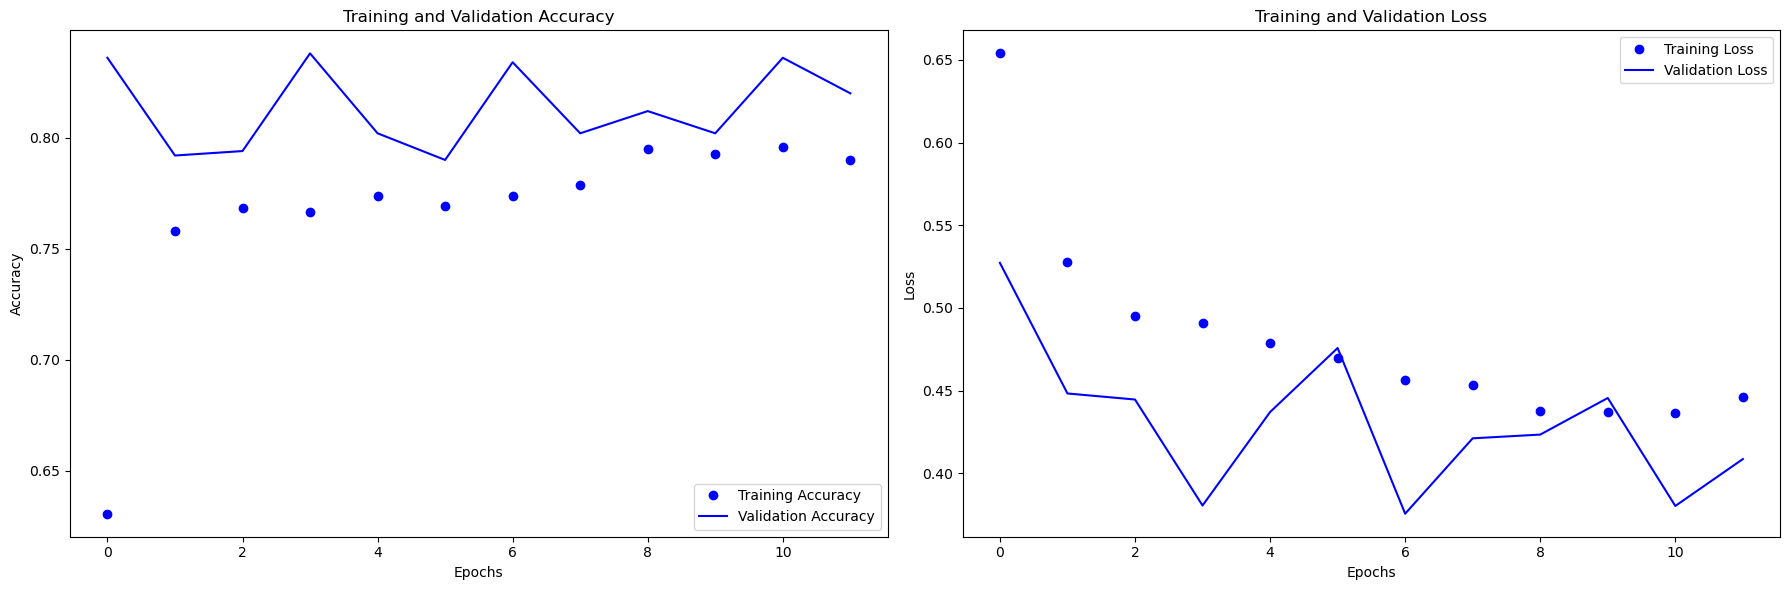

In [19]:
plot_graph(history)

In [21]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=20,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_121 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_120 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_121 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_122 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_123 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_124 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - acc: 0.5532 - loss: 0.6818 - val_acc: 0.8180 - val_loss: 0.5357
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7538 - loss: 0.5423 - val_acc: 0.7780 - val_loss: 0.5199
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - acc: 0.7344 - loss: 0.5414 - val_acc: 0.8360 - val_loss: 0.4148
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - acc: 0.7510 - loss: 0.5130 - val_acc: 0.8040 - val_loss: 0.4462
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - acc: 0.7857 - loss: 0.4642 - val_acc: 0.7880 - val_loss: 0.4915
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - acc: 0.7646 - loss: 0.4940 - val_acc: 0.8180 - val_loss: 0.4055
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7721 - loss: 0.4682 - val_acc: 0.8060 - val_loss: 0.4300
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7955 - loss: 0.4337 - 

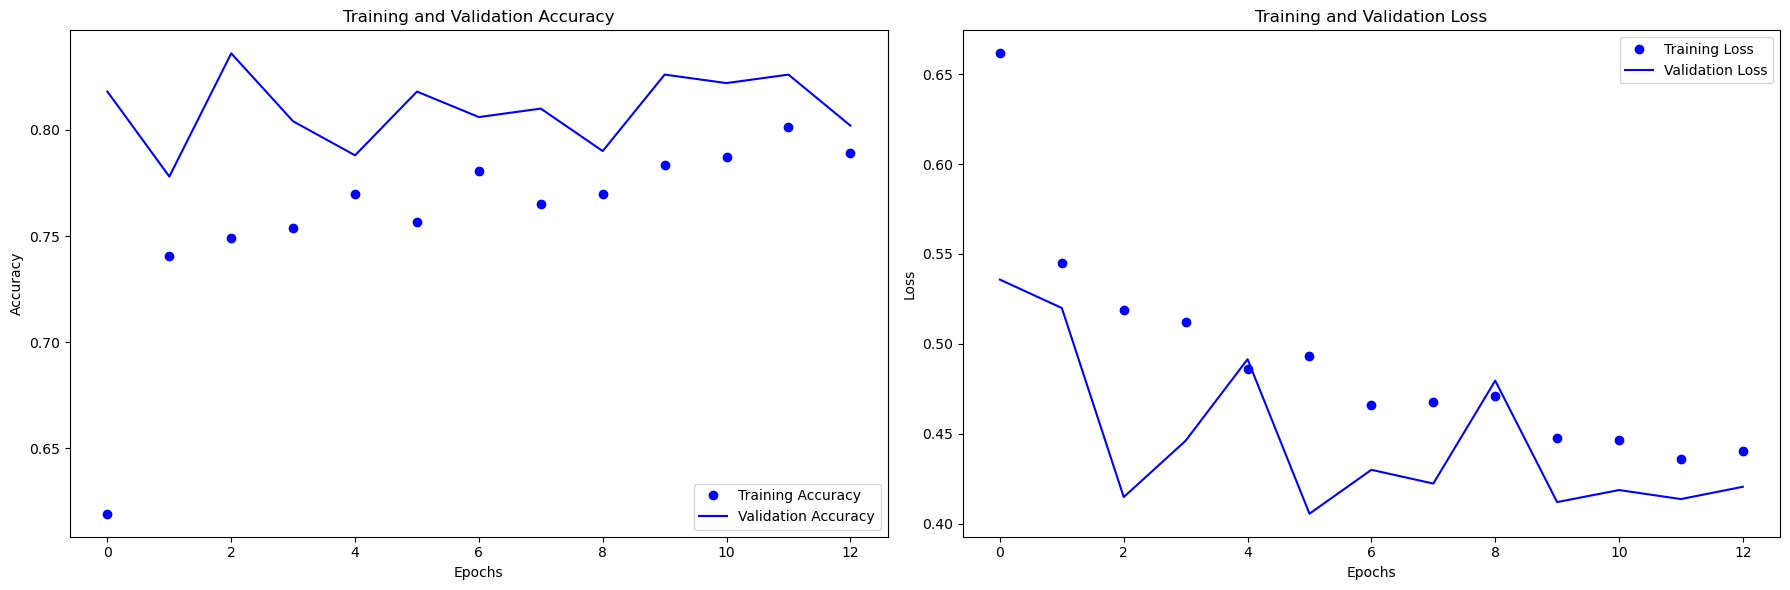

In [22]:
plot_graph(history)

activation functions + max pooling + layers

### Activation Functions

In [23]:
activation_functions = [
    ReLU(),
    LeakyReLU(alpha=0.2),
    Activation(gelu),
    ELU(),
    Activation('tanh')
]

histories = {}

for activation_func in activation_functions:
    print("Activation Function:", activation_func.__class__.__name__)

    img_size = 150

    model = models.Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=(img_size, img_size, 3)))
    model.add(activation_func)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(activation_func)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(activation_func)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(activation_func)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(activation_func)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(activation_func)
    model.add(Dense(256))
    model.add(activation_func)
    model.add(Dense(128))
    model.add(activation_func)

    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['acc'])

    train_generator, validation_generator = image_gen_aug1(batch_size=32)

    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)

    print('\n')

    histories[activation_func.__class__.__name__] = history.history

Activation Function: ReLU


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_125 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_127 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_126 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_128 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_127 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_128 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_129 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 594ms/step - acc: 0.5955 - loss: 0.6794 - val_acc: 0.7760 - val_loss: 0.5394
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - acc: 0.7368 - loss: 0.5544 - val_acc: 0.8020 - val_loss: 0.4264
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - acc: 0.7578 - loss: 0.4955 - val_acc: 0.7880 - val_loss: 0.4415
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - acc: 0.7581 - loss: 0.5162 - val_acc: 0.8480 - val_loss: 0.3793
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - acc: 0.7493 - loss: 0.5307 - val_acc: 0.7720 - val_loss: 0.5119
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - acc: 0.7793 - loss: 0.4894 - val_acc: 0.8580 - val_loss: 0.3666
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - acc: 0.7789 - loss: 0.4837 - val_acc: 0.8640 - val_loss: 0.3617
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - acc: 0.7914 - loss: 0.4570 - 

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_131 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_130 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_131 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_132 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_133 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_135 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_134 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - acc: 0.6242 - loss: 0.6725 - val_acc: 0.8200 - val_loss: 0.4794
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - acc: 0.7466 - loss: 0.5399 - val_acc: 0.8320 - val_loss: 0.4336
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - acc: 0.7374 - loss: 0.5327 - val_acc: 0.8000 - val_loss: 0.4338
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - acc: 0.7440 - loss: 0.5293 - val_acc: 0.8080 - val_loss: 0.4335
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - acc: 0.7656 - loss: 0.4760 - val_acc: 0.7860 - val_loss: 0.4441
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - acc: 0.7635 - loss: 0.5022 - val_acc: 0.8200 - val_loss: 0.4087
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - acc: 0.7533 - loss: 0.4997 - val_acc: 0.8140 - val_loss: 0.4139
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - acc: 0.7763 - loss: 0.4732 - 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_136 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_135 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_137 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_136 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_138 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_137 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_139 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_138 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_140 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_139 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - acc: 0.5308 - loss: 0.6891 - val_acc: 0.6840 - val_loss: 0.6003
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - acc: 0.6864 - loss: 0.6049 - val_acc: 0.7880 - val_loss: 0.4831
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - acc: 0.7479 - loss: 0.5246 - val_acc: 0.8140 - val_loss: 0.4165
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - acc: 0.7542 - loss: 0.5263 - val_acc: 0.7700 - val_loss: 0.5065
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - acc: 0.7382 - loss: 0.5340 - val_acc: 0.7840 - val_loss: 0.4797
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - acc: 0.7506 - loss: 0.5216 - val_acc: 0.7980 - val_loss: 0.4332
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - acc: 0.7644 - loss: 0.5078 - val_acc: 0.7960 - val_loss: 0.4235
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - acc: 0.7549 - loss: 0.5051 - 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_141 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_140 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_142 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_141 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_143 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_142 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_144 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_143 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_145 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_144 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 321ms/step - acc: 0.6730 - loss: 0.6277 - val_acc: 0.7740 - val_loss: 0.4899
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7584 - loss: 0.4860 - val_acc: 0.7760 - val_loss: 0.4907
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - acc: 0.7777 - loss: 0.4819 - val_acc: 0.8020 - val_loss: 0.4409
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - acc: 0.7480 - loss: 0.5077 - val_acc: 0.7280 - val_loss: 0.5804
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - acc: 0.7739 - loss: 0.4917 - val_acc: 0.7420 - val_loss: 0.5659
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - acc: 0.7755 - loss: 0.4852 - val_acc: 0.7920 - val_loss: 0.4566
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - acc: 0.7667 - loss: 0.4933 - val_acc: 0.7520 - val_loss: 0.5327
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - acc: 0.7704 - loss: 0.4782 - 

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_146 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_145 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_147 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_146 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_148 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_147 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_149 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_148 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_150 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_149 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_29 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - acc: 0.6177 - loss: 0.6303 - val_acc: 0.7520 - val_loss: 0.5366
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - acc: 0.7778 - loss: 0.5023 - val_acc: 0.7840 - val_loss: 0.4481
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - acc: 0.7618 - loss: 0.4948 - val_acc: 0.8100 - val_loss: 0.4120
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - acc: 0.7558 - loss: 0.4998 - val_acc: 0.7960 - val_loss: 0.4257
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - acc: 0.7668 - loss: 0.4850 - val_acc: 0.8000 - val_loss: 0.4255
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - acc: 0.7595 - loss: 0.5069 - val_acc: 0.7960 - val_loss: 0.4221
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - acc: 0.7707 - loss: 0.4828 - val_acc: 0.7900 - val_loss: 0.4429
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - acc: 0.7856 - loss: 0.4744 - 

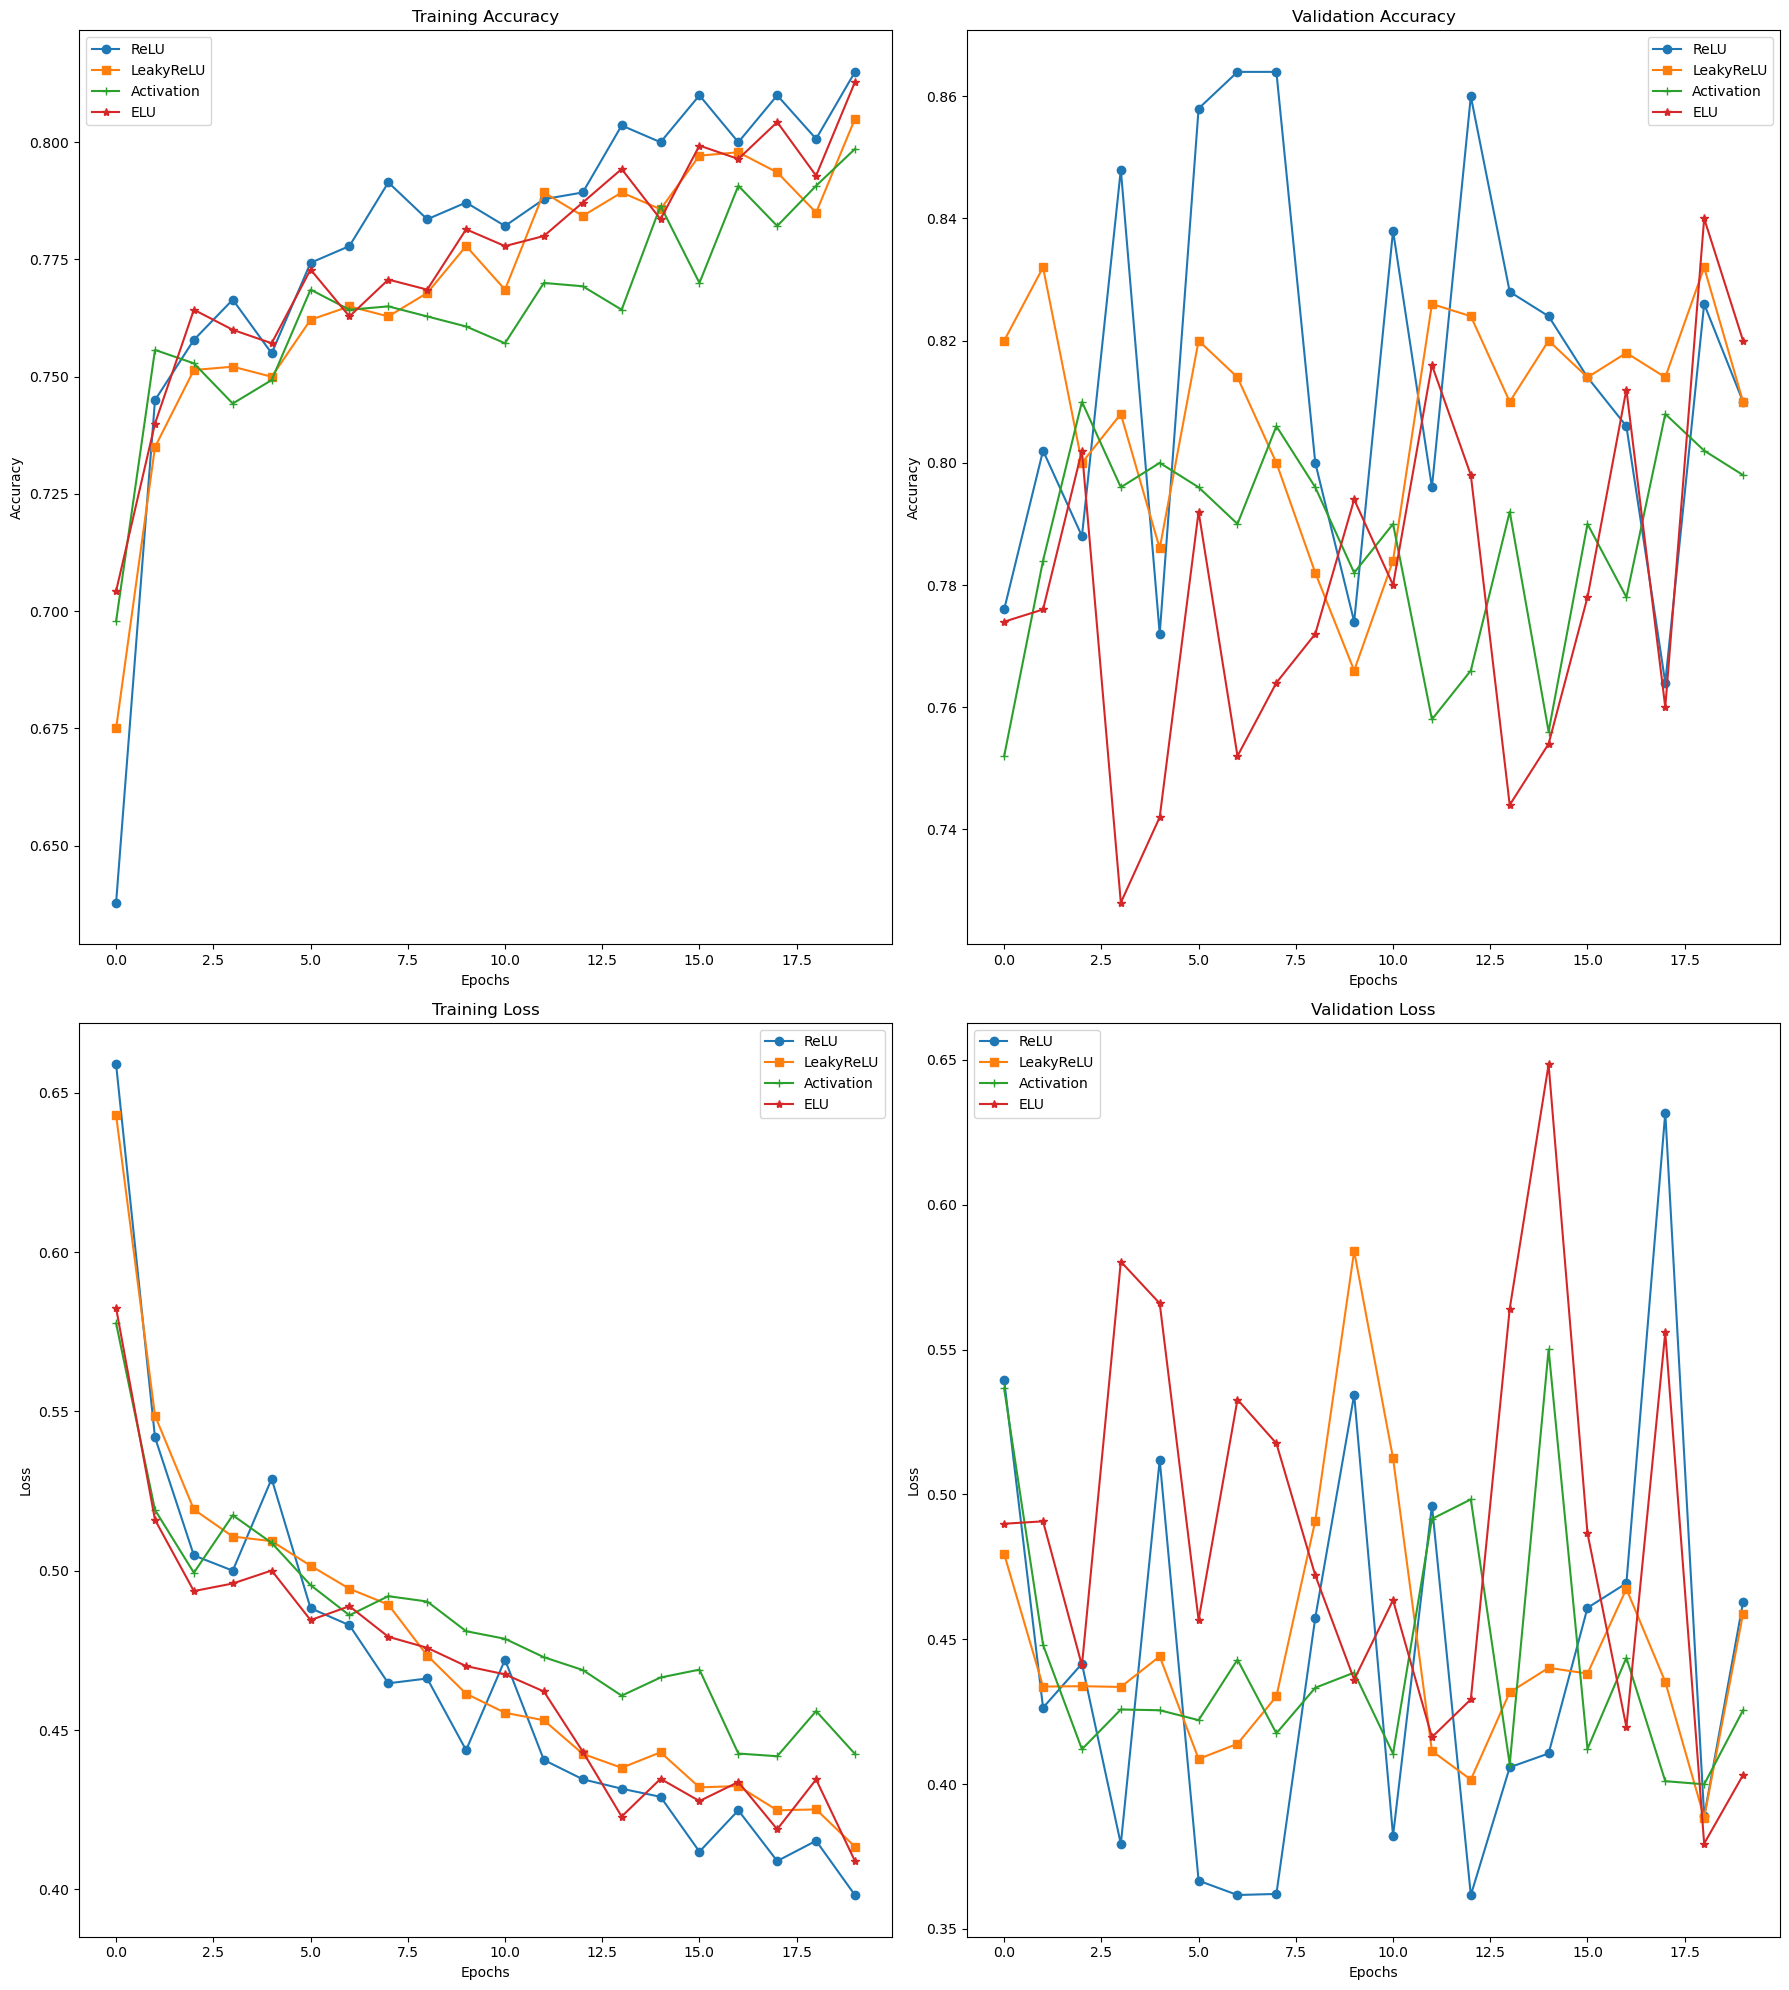

In [24]:
param_plot(histories)

### Global Average Pooling (GAP)

In [30]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D()) 

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_166 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_165 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_167 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_166 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_168 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_167 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_169 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_168 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_170 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_169 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 376,865 (1.44 MB)

 Trainable params: 376,865 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - acc: 0.5734 - loss: 0.6905 - val_acc: 0.7720 - val_loss: 0.6547
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - acc: 0.7090 - loss: 0.6337 - val_acc: 0.7960 - val_loss: 0.4588
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7578 - loss: 0.5166 - val_acc: 0.7140 - val_loss: 0.6220
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - acc: 0.7525 - loss: 0.5277 - val_acc: 0.8080 - val_loss: 0.4377
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - acc: 0.7643 - loss: 0.5009 - val_acc: 0.8320 - val_loss: 0.3990
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - acc: 0.7614 - loss: 0.4844 - val_acc: 0.8300 - val_loss: 0.4020
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - acc: 0.7618 - loss: 0.4825 - val_acc: 0.7940 - val_loss: 0.4461
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - acc: 0.7725 - loss: 0.4789 - 

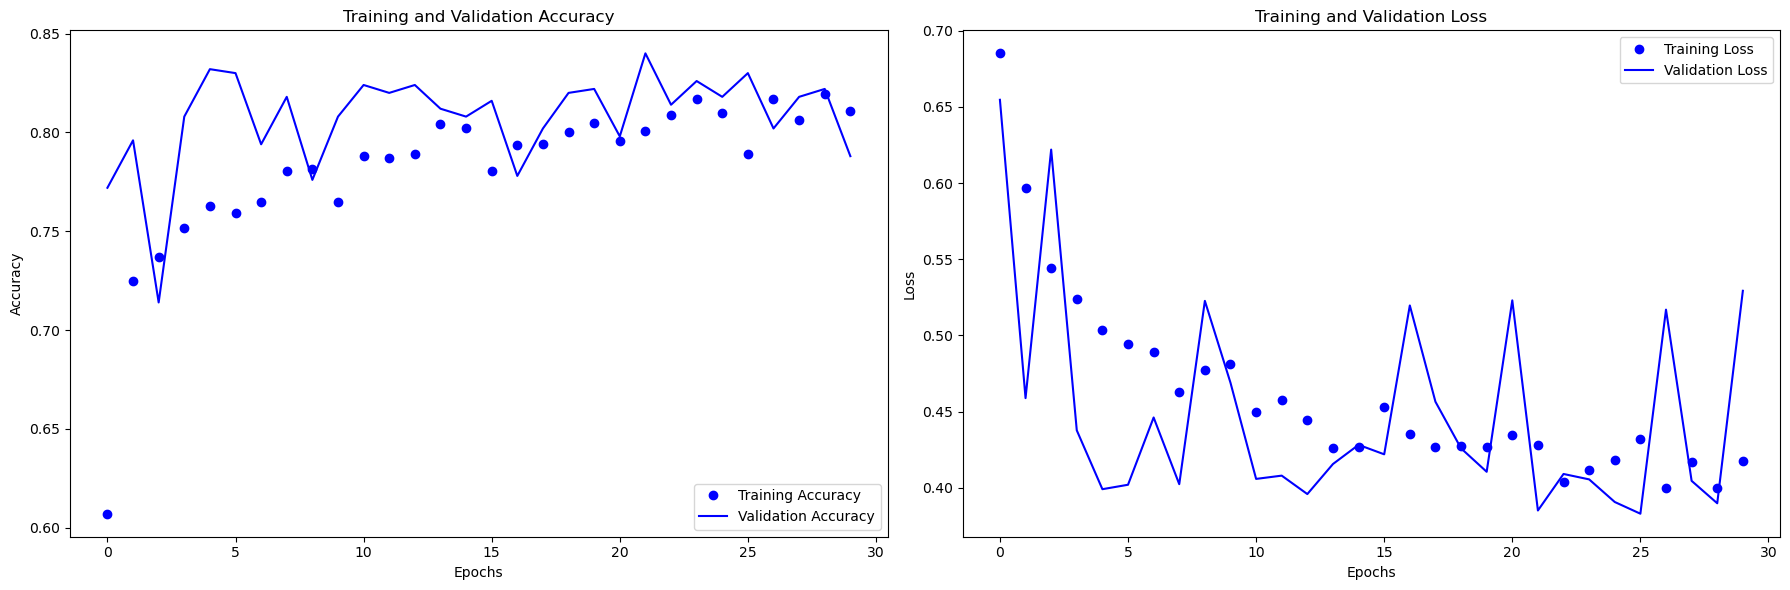

In [31]:
plot_graph(history)

In [32]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_171 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_170 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_172 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_171 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_173 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_172 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_174 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_173 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_175 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_174 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - acc: 0.5980 - loss: 0.6743 - val_acc: 0.8140 - val_loss: 0.4739
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - acc: 0.7418 - loss: 0.5349 - val_acc: 0.8180 - val_loss: 0.4226
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7667 - loss: 0.5010 - val_acc: 0.8260 - val_loss: 0.3996
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - acc: 0.7776 - loss: 0.4739 - val_acc: 0.8420 - val_loss: 0.3656
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - acc: 0.7764 - loss: 0.4658 - val_acc: 0.8020 - val_loss: 0.4186
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - acc: 0.7767 - loss: 0.4529 - val_acc: 0.7600 - val_loss: 0.5526
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - acc: 0.7642 - loss: 0.4939 - val_acc: 0.8300 - val_loss: 0.3736
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - acc: 0.7888 - loss: 0.4404 - 

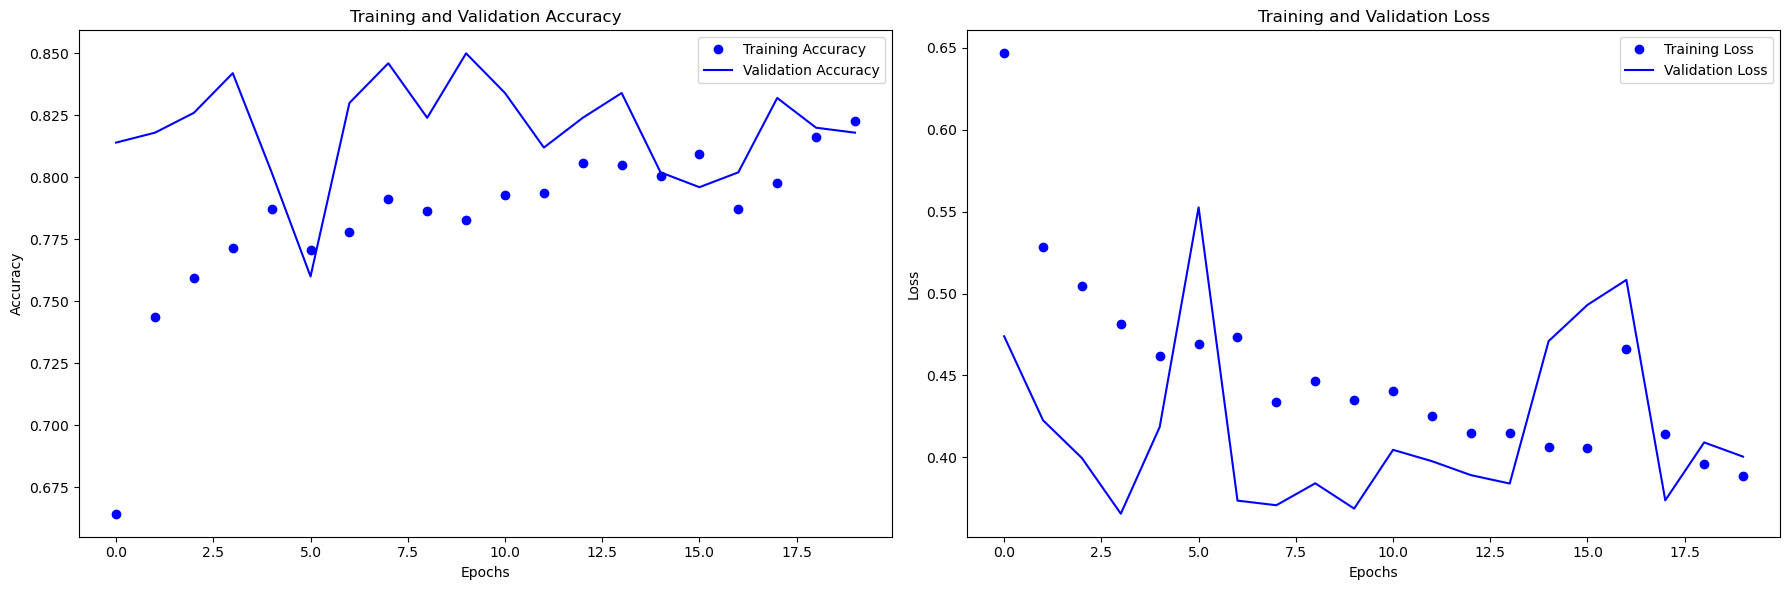

In [33]:
plot_graph(history)

In [34]:
model.save('model1.keras')

In [38]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_199 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_197 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_200 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_198 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_201 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_199 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_202 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_200 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_203 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_201 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_34 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737,825 (2.81 MB)

 Trainable params: 737,825 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - acc: 0.5240 - loss: 0.6873 - val_acc: 0.7820 - val_loss: 0.6076
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - acc: 0.7052 - loss: 0.6021 - val_acc: 0.7760 - val_loss: 0.5037
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7491 - loss: 0.5187 - val_acc: 0.7540 - val_loss: 0.5445
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - acc: 0.7435 - loss: 0.5243 - val_acc: 0.8280 - val_loss: 0.3938
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7713 - loss: 0.4871 - val_acc: 0.8160 - val_loss: 0.3914
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - acc: 0.7697 - loss: 0.4736 - val_acc: 0.8280 - val_loss: 0.3793
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - acc: 0.7929 - loss: 0.4517 - val_acc: 0.8680 - val_loss: 0.3791
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - acc: 0.7759 - loss: 0.4608 - 

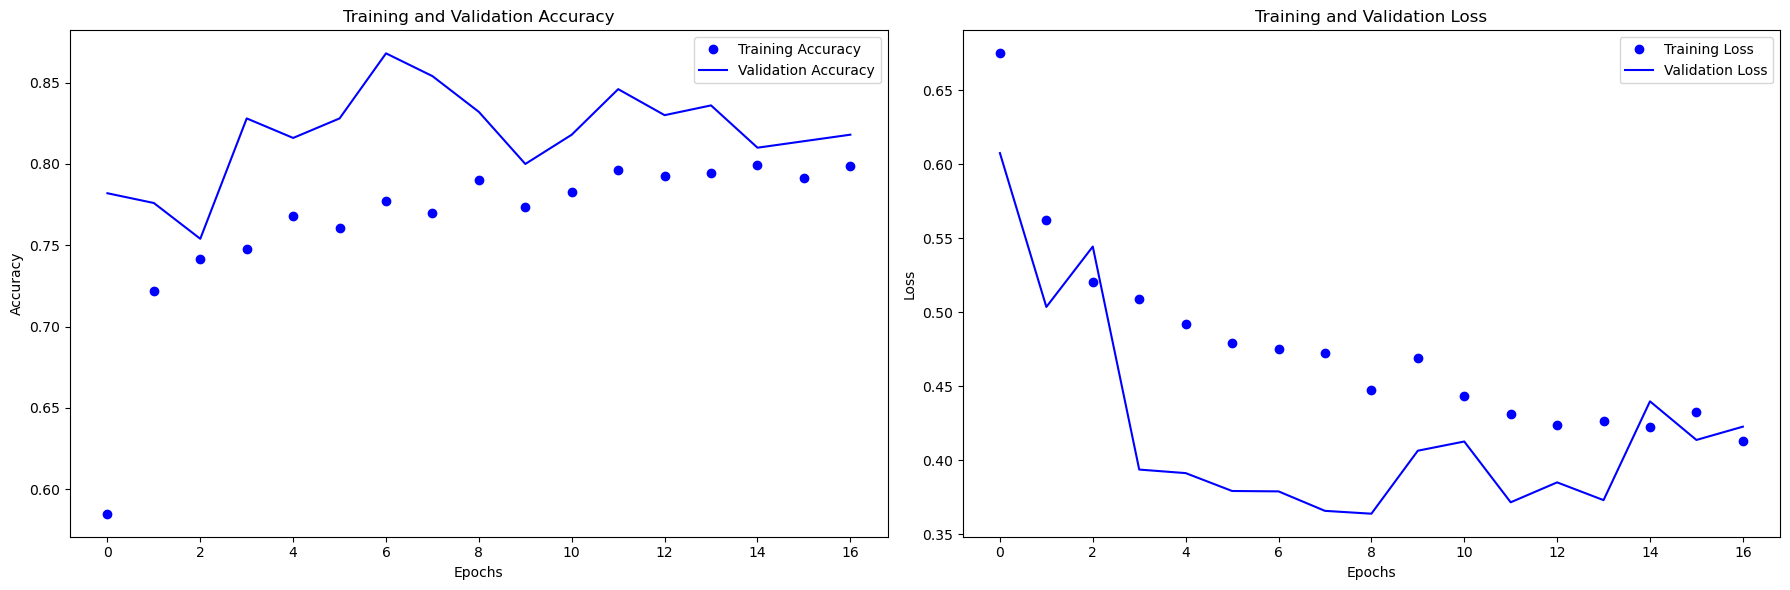

In [39]:
plot_graph(history)

In [40]:
model.save('model2.keras')

In [54]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_204 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_202 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_205 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_203 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_204 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_207 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_205 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_208 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_206 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245,537 (959.13 KB)

 Trainable params: 245,537 (959.13 KB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - acc: 0.5981 - loss: 0.6784 - val_acc: 0.7960 - val_loss: 0.5678
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - acc: 0.7643 - loss: 0.5673 - val_acc: 0.8120 - val_loss: 0.4322
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - acc: 0.7473 - loss: 0.5203 - val_acc: 0.8180 - val_loss: 0.4211
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - acc: 0.7683 - loss: 0.4976 - val_acc: 0.8400 - val_loss: 0.3883
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - acc: 0.7718 - loss: 0.4754 - val_acc: 0.8360 - val_loss: 0.3695
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - acc: 0.7775 - loss: 0.4632 - val_acc: 0.7920 - val_loss: 0.4517
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - acc: 0.7597 - loss: 0.4911 - val_acc: 0.8500 - val_loss: 0.3705
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - acc: 0.7926 - loss: 0.4726 - 

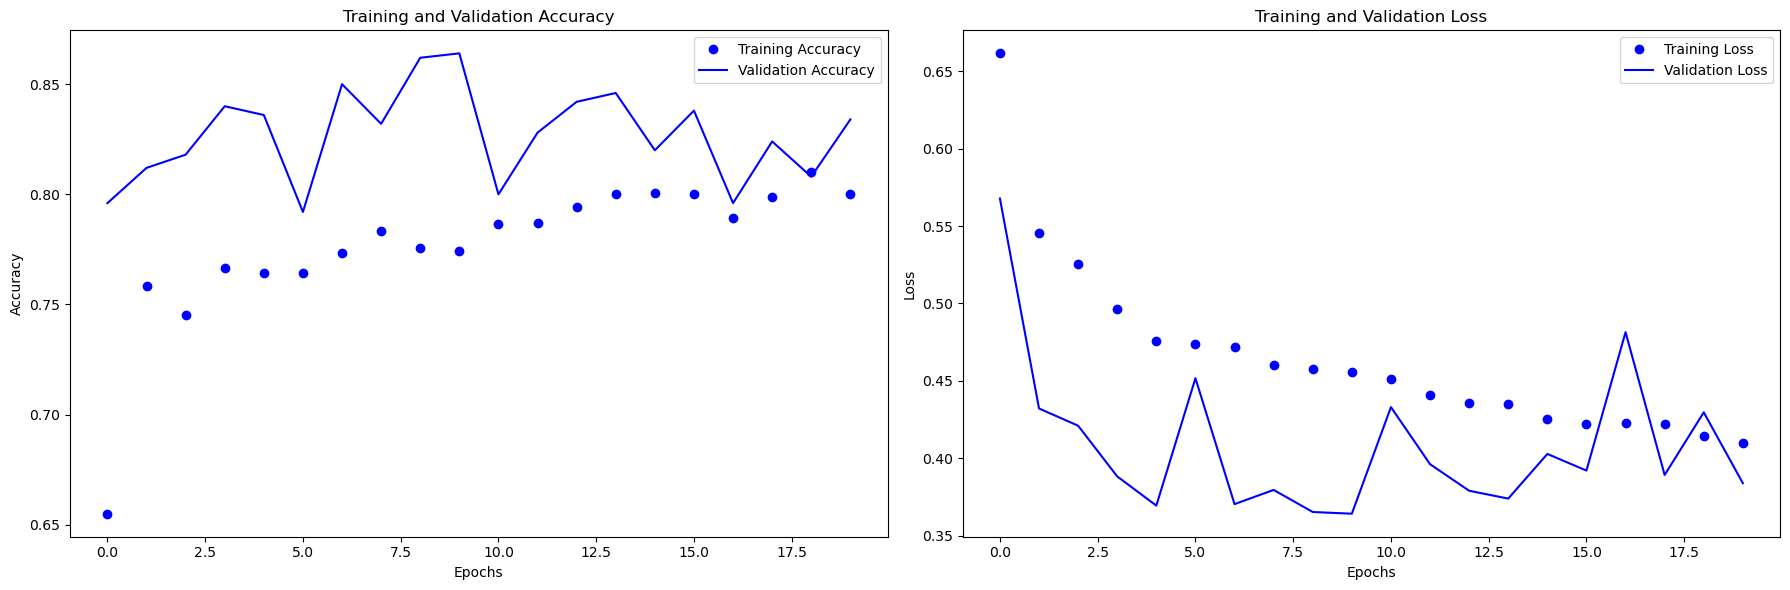

In [55]:
plot_graph(history)

In [56]:
model.save("model3.keras")

In [58]:
img_size = 150

model = models.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['acc'])

train_generator, validation_generator = image_gen_aug1(batch_size=32)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping])

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_209 (Conv2D)                  │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_207 (MaxPooling2D)     │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_210 (Conv2D)                  │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_208 (MaxPooling2D)     │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_211 (Conv2D)                  │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_209 (MaxPooling2D)     │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_212 (Conv2D)                  │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_210 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_213 (Conv2D)                  │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_211 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245,537 (959.13 KB)

 Trainable params: 245,537 (959.13 KB)

 Non-trainable params: 0 (0.00 B)

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - acc: 0.6077 - loss: 0.6810 - val_acc: 0.7140 - val_loss: 0.5965
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - acc: 0.7537 - loss: 0.5565 - val_acc: 0.8160 - val_loss: 0.4401
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - acc: 0.7495 - loss: 0.4991 - val_acc: 0.7680 - val_loss: 0.5054
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - acc: 0.7644 - loss: 0.5111 - val_acc: 0.8440 - val_loss: 0.4142
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - acc: 0.7526 - loss: 0.5032 - val_acc: 0.7720 - val_loss: 0.4674
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - acc: 0.7587 - loss: 0.4867 - val_acc: 0.8100 - val_loss: 0.3998
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - acc: 0.7827 - loss: 0.4721 - val_acc: 0.8260 - val_loss: 0.3851
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - acc: 0.7922 - loss: 0.4592 - 

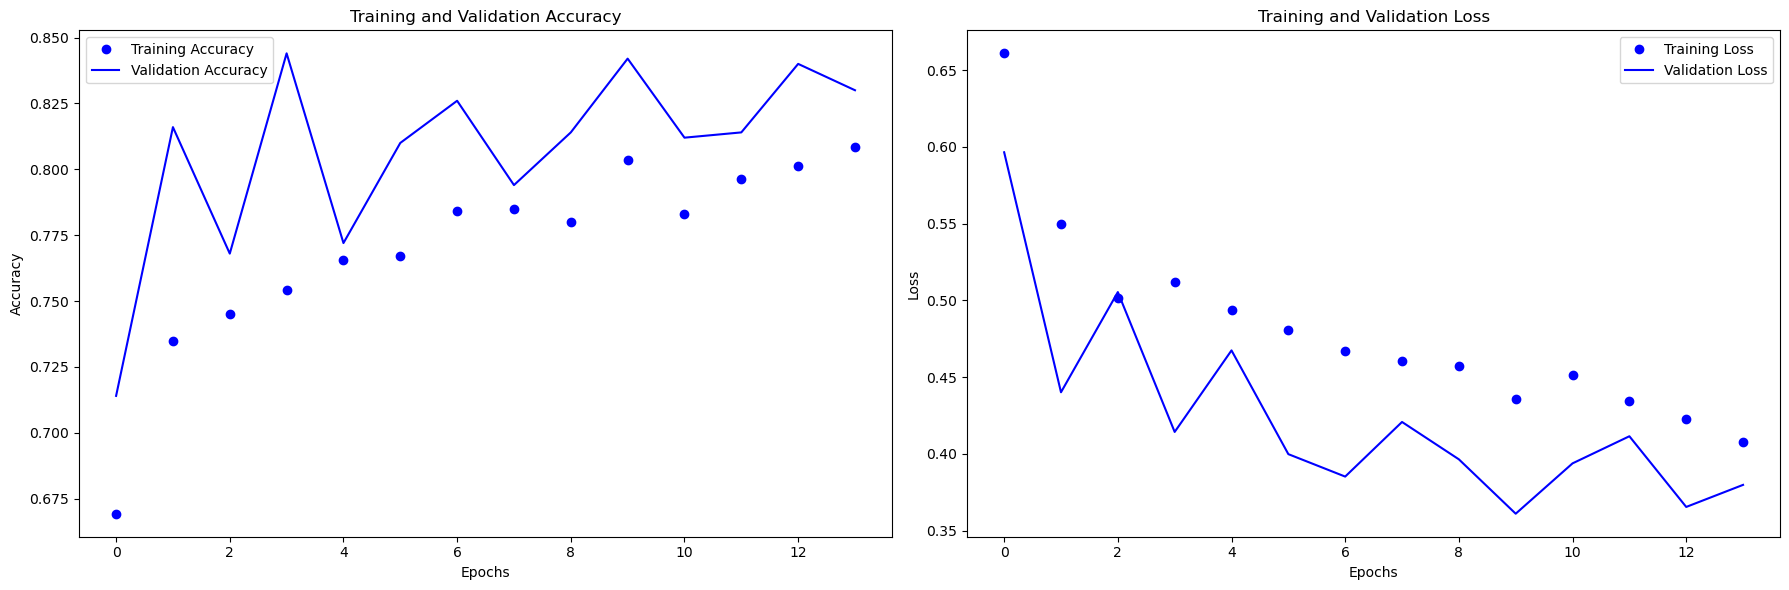

In [59]:
plot_graph(history)

In [62]:
from tensorflow.keras.applications import MobileNet #V1 of Mobile Net
from tensorflow.keras.applications.mobilenet import preprocess_input

def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5          # Factor by which the learning rate will be reduced
    epochs_drop = 10    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

pretrained_mn_model = MobileNet((150,150,3),
                              include_top=False,
                              weights='imagenet')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet preprocessing
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images by up to 20%
    zoom_range=0.2,   # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest')  # Fill mode for newly created pixels

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

pretrained_mn_model.trainable = False

pt_model = models.Sequential()
pt_model.add(pretrained_mn_model)
pt_model.add(layers.GlobalAveragePooling2D())
pt_model.add(layers.Dense(256, activation='relu'))
pt_model.add(layers.Dense(1, activation='sigmoid'))

pt_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("pt_model4.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(step_decay)

pt_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

history = pt_model.fit(
  train_generator,
  epochs=30,
  validation_data=validation_generator,
  callbacks=[early_stopping, checkpoint])


Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ ?                           │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - acc: 0.6121 - loss: 0.7196
Epoch 1: val_acc improved from -inf to 0.84000, saving model to pt_model4.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 511ms/step - acc: 0.6141 - loss: 0.7165 - val_acc: 0.8400 - val_loss: 0.3712
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - acc: 0.8432 - loss: 0.3629
Epoch 2: val_acc improved from 0.84000 to 0.84600, saving model to pt_model4.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - acc: 0.8430 - loss: 0.3629 - val_acc: 0.8460 - val_loss: 0.3395
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - acc: 0.8636 - loss: 0.3151
Epoch 3: val_acc improved from 0.84600 to 0.87400, saving model to pt_model4.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - acc: 0.8636 - loss: 0.3148 - val_acc: 0.8740 - val_loss: 0.3047
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - acc: 0.8957 - loss: 0.2482
Epoch 4: val_acc improved from 0.87400 to 0.87600, saving model to pt_model4.keras
44/44 ━━━━━━━━━━━━━━━━━

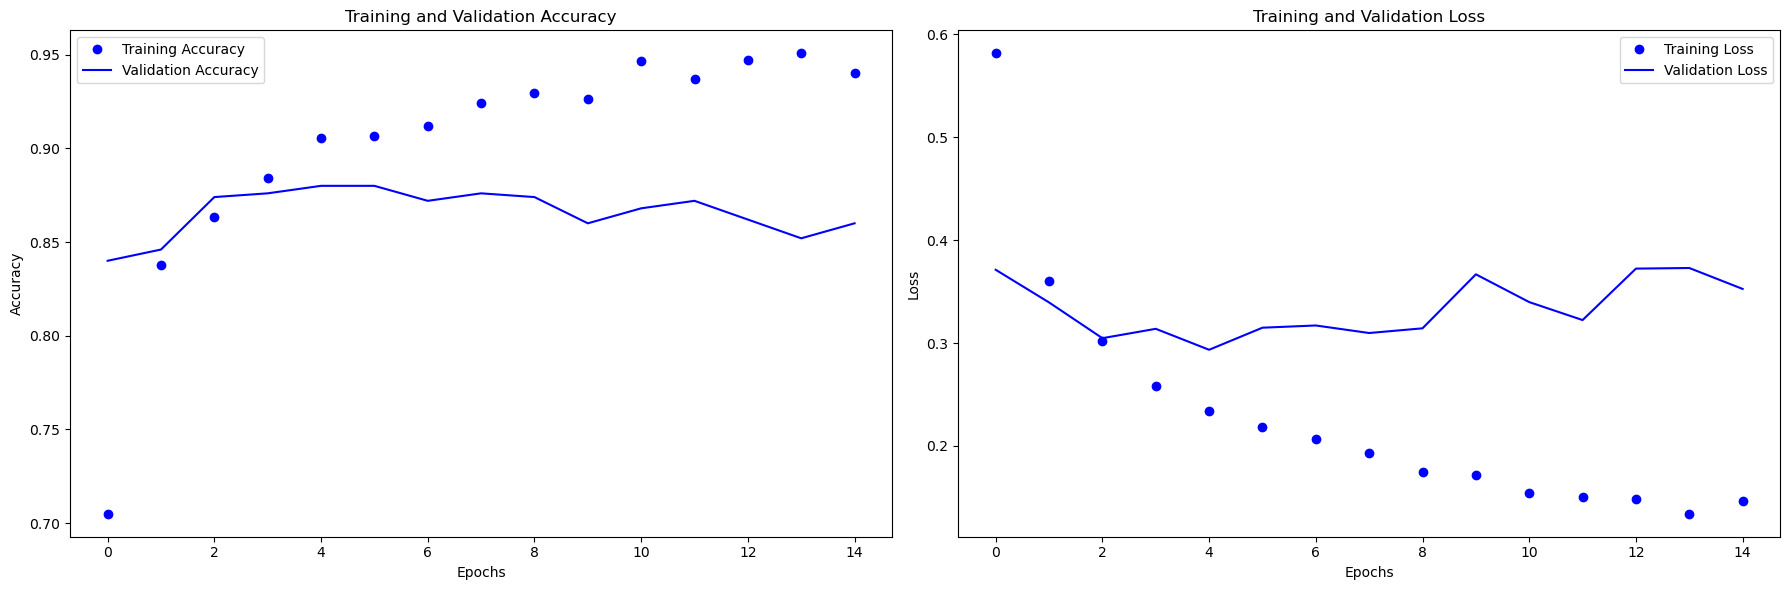

In [63]:
plot_graph(history)

In [65]:
def print_layer_trainable():
    for layer in pretrained_mn_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()

False:	input_layer_45
False:	conv1
False:	conv1_bn
False:	conv1_relu
False:	conv_dw_1
False:	conv_dw_1_bn
False:	conv_dw_1_relu
False:	conv_pw_1
False:	conv_pw_1_bn
False:	conv_pw_1_relu
False:	conv_pad_2
False:	conv_dw_2
False:	conv_dw_2_bn
False:	conv_dw_2_relu
False:	conv_pw_2
False:	conv_pw_2_bn
False:	conv_pw_2_relu
False:	conv_dw_3
False:	conv_dw_3_bn
False:	conv_dw_3_relu
False:	conv_pw_3
False:	conv_pw_3_bn
False:	conv_pw_3_relu
False:	conv_pad_4
False:	conv_dw_4
False:	conv_dw_4_bn
False:	conv_dw_4_relu
False:	conv_pw_4
False:	conv_pw_4_bn
False:	conv_pw_4_relu
False:	conv_dw_5
False:	conv_dw_5_bn
False:	conv_dw_5_relu
False:	conv_pw_5
False:	conv_pw_5_bn
False:	conv_pw_5_relu
False:	conv_pad_6
False:	conv_dw_6
False:	conv_dw_6_bn
False:	conv_dw_6_relu
False:	conv_pw_6
False:	conv_pw_6_bn
False:	conv_pw_6_relu
False:	conv_dw_7
False:	conv_dw_7_bn
False:	conv_dw_7_relu
False:	conv_pw_7
False:	conv_pw_7_bn
False:	conv_pw_7_relu
False:	conv_dw_8
False:	conv_dw_8_bn
False:	conv_dw

In [66]:
#Only training the last three convolutional layers
def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5          # Factor by which the learning rate will be reduced
    epochs_drop = 10    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

pretrained_mn_model = MobileNet((150,150,3),
                              include_top=False,
                              weights='imagenet')

    
pt_model2 = models.Sequential()
pt_model2.add(pretrained_mn_model)
pt_model2.add(layers.GlobalAveragePooling2D())
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(128, activation='relu'))
pt_model2.add(layers.Dense(1, activation='sigmoid'))

trainable_layers = 3

for layer in pt_model2.layers[:-trainable_layers]:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("pt_model5.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(step_decay)

pt_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet preprocessing
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images by up to 20%
    zoom_range=0.2,   # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest')  # Fill mode for newly created pixels

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = pt_model2.fit(
  train_generator,
  epochs=50,
  validation_data=validation_generator,
  callbacks=[early_stopping, checkpoint, lr_scheduler])

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - acc: 0.6981 - loss: 0.5532
Epoch 1: val_acc improved from -inf to 0.82800, saving model to pt_model5.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 461ms/step - acc: 0.6995 - loss: 0.5515 - val_acc: 0.8280 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - acc: 0.8354 - loss: 0.3609
Epoch 2: val_acc improved from 0.82800 to 0.83400, saving model to pt_model5.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - acc: 0.8353 - loss: 0.3609 - val_acc: 0.8340 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - acc: 0.8668 - loss: 0.3145
Epoch 3: val_acc improved from 0.83400 to 0.84200, saving model to pt_model5.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - acc: 0.8668 - loss: 0.3145 - val_acc: 0.8420 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━

In [67]:
#Only training the last three convolutional layers

pretrained_mn_model = MobileNet((150,150,3),
                              include_top=False,
                              weights='imagenet')

    
pt_model2 = models.Sequential()
pt_model2.add(pretrained_mn_model)
pt_model2.add(layers.GlobalAveragePooling2D())
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(128, activation='relu'))
pt_model2.add(layers.Dense(1, activation='sigmoid'))

trainable_layers = 3

for layer in pt_model2.layers[:-trainable_layers]:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("pt_model5.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

pt_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet preprocessing
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images by up to 20%
    zoom_range=0.2,   # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest')  # Fill mode for newly created pixels

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = pt_model2.fit(
  train_generator,
  epochs=50,
  validation_data=validation_generator,
  callbacks=[early_stopping, checkpoint])

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - acc: 0.6498 - loss: 0.6244
Epoch 1: val_acc improved from -inf to 0.87800, saving model to pt_model5.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - acc: 0.6517 - loss: 0.6223 - val_acc: 0.8780 - val_loss: 0.3041
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - acc: 0.8315 - loss: 0.3566
Epoch 2: val_acc did not improve from 0.87800
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - acc: 0.8318 - loss: 0.3567 - val_acc: 0.8300 - val_loss: 0.3616
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - acc: 0.8548 - loss: 0.3221
Epoch 3: val_acc did not improve from 0.87800
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - acc: 0.8549 - loss: 0.3219 - val_acc: 0.8740 - val_loss: 0.2920
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - acc: 0.8714 - loss: 0.2742
Epoch 4: val_acc did not improve from 0.87800
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - acc: 0.

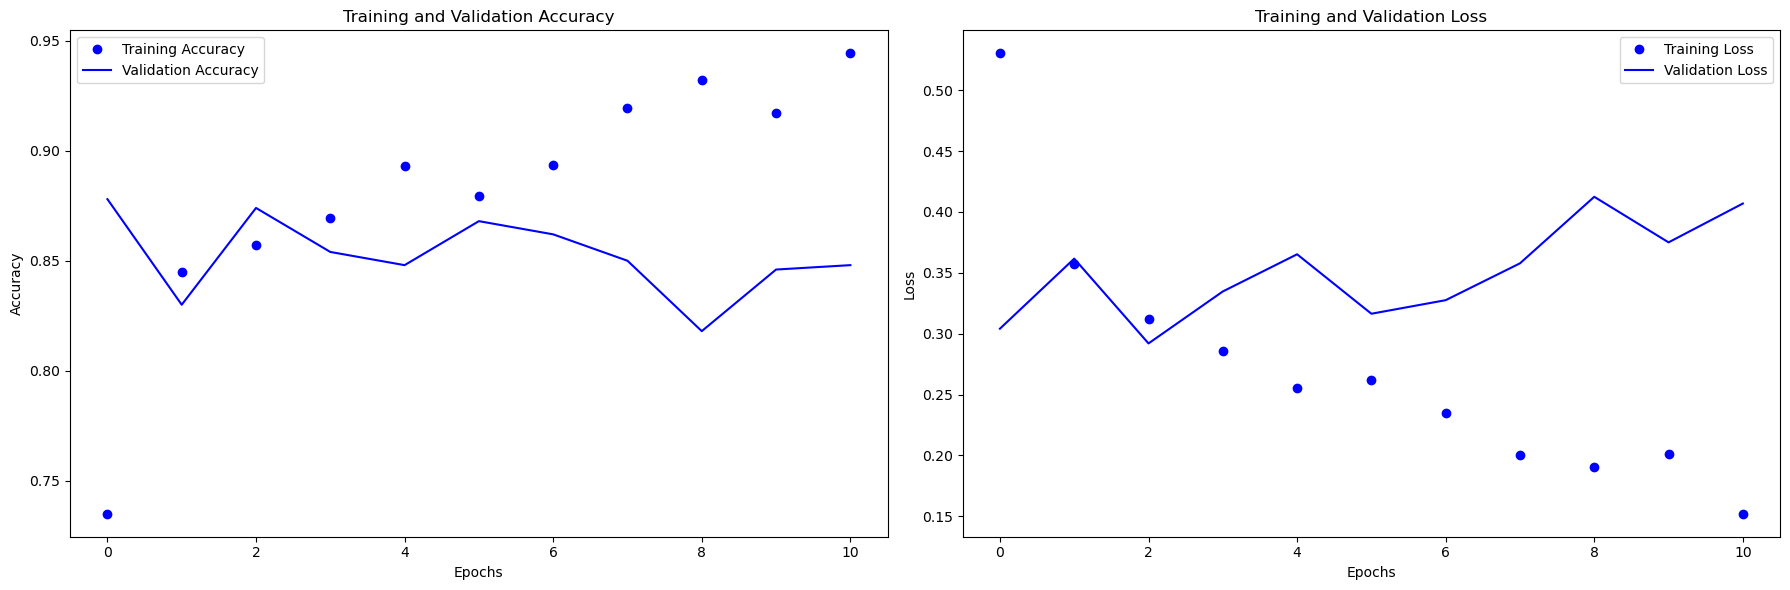

In [68]:
plot_graph(history)

In [69]:
#Only training the last three convolutional layers

pretrained_mn_model = MobileNet((150,150,3),
                              include_top=False,
                              weights='imagenet')

    
pt_model2 = models.Sequential()
pt_model2.add(pretrained_mn_model)
pt_model2.add(layers.GlobalAveragePooling2D())
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(Dropout(0.3))
pt_model2.add(layers.Dense(128, activation='relu'))
pt_model2.add(layers.Dense(1, activation='sigmoid'))

trainable_layers = 3

for layer in pt_model2.layers[:-trainable_layers]:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("pt_model6.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

pt_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet preprocessing
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images by up to 20%
    zoom_range=0.2,   # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest')  # Fill mode for newly created pixels

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = pt_model2.fit(
  train_generator,
  epochs=50,
  validation_data=validation_generator,
  callbacks=[early_stopping, checkpoint])

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - acc: 0.5810 - loss: 0.6927
Epoch 1: val_acc improved from -inf to 0.79600, saving model to pt_model6.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - acc: 0.5829 - loss: 0.6907 - val_acc: 0.7960 - val_loss: 0.4717
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - acc: 0.7572 - loss: 0.5008
Epoch 2: val_acc improved from 0.79600 to 0.83200, saving model to pt_model6.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - acc: 0.7571 - loss: 0.5007 - val_acc: 0.8320 - val_loss: 0.4059
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - acc: 0.7848 - loss: 0.4686
Epoch 3: val_acc improved from 0.83200 to 0.84800, saving model to pt_model6.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - acc: 0.7847 - loss: 0.4686 - val_acc: 0.8480 - val_loss: 0.3933
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - acc: 0.7883 - loss: 0.4458
Epoch 4: val_acc did no

Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - acc: 0.8431 - loss: 0.3394
Epoch 27: val_acc did not improve from 0.86200
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 462ms/step - acc: 0.8430 - loss: 0.3395 - val_acc: 0.8280 - val_loss: 0.3811
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - acc: 0.8252 - loss: 0.3588
Epoch 28: val_acc did not improve from 0.86200
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - acc: 0.8257 - loss: 0.3585 - val_acc: 0.8460 - val_loss: 0.3763
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - acc: 0.8458 - loss: 0.3384
Epoch 29: val_acc did not improve from 0.86200
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - acc: 0.8459 - loss: 0.3384 - val_acc: 0.8500 - val_loss: 0.3675
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - acc: 0.8388 - loss: 0.3478
Epoch 30: val_acc did not improve from 0.86200
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - acc: 0.8389 - loss: 0.3477 - val_acc: 0.8520 - val_loss: 0.3754
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step

In [71]:
#Only training the last three convolutional layers

pretrained_mn_model = MobileNet((150,150,3),
                              include_top=False,
                              weights='imagenet')

    
pt_model2 = models.Sequential()
pt_model2.add(pretrained_mn_model)
pt_model2.add(layers.GlobalAveragePooling2D())
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(layers.Dense(256, activation='relu'))
pt_model2.add(Dropout(0.2))
pt_model2.add(layers.Dense(128, activation='relu'))
pt_model2.add(layers.Dense(1, activation='sigmoid'))

trainable_layers = 2

for layer in pt_model2.layers[:-trainable_layers]:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("pt_model7.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

pt_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet preprocessing
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images by up to 20%
    zoom_range=0.2,   # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest')  # Fill mode for newly created pixels

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = pt_model2.fit(
  train_generator,
  epochs=50,
  validation_data=validation_generator,
  callbacks=[early_stopping, checkpoint])

Found 1400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - acc: 0.6327 - loss: 0.6556
Epoch 1: val_acc improved from -inf to 0.81000, saving model to pt_model7.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 465ms/step - acc: 0.6341 - loss: 0.6542 - val_acc: 0.8100 - val_loss: 0.4486
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - acc: 0.7658 - loss: 0.4906
Epoch 2: val_acc did not improve from 0.81000
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - acc: 0.7661 - loss: 0.4902 - val_acc: 0.7700 - val_loss: 0.4594
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - acc: 0.7856 - loss: 0.4566
Epoch 3: val_acc did not improve from 0.81000
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - acc: 0.7857 - loss: 0.4564 - val_acc: 0.7960 - val_loss: 0.4264
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - acc: 0.7768 - loss: 0.4905
Epoch 4: val_acc improved from 0.81000 to 0.83000, saving model to pt_model7.keras
44/44 ━━━━━━━━

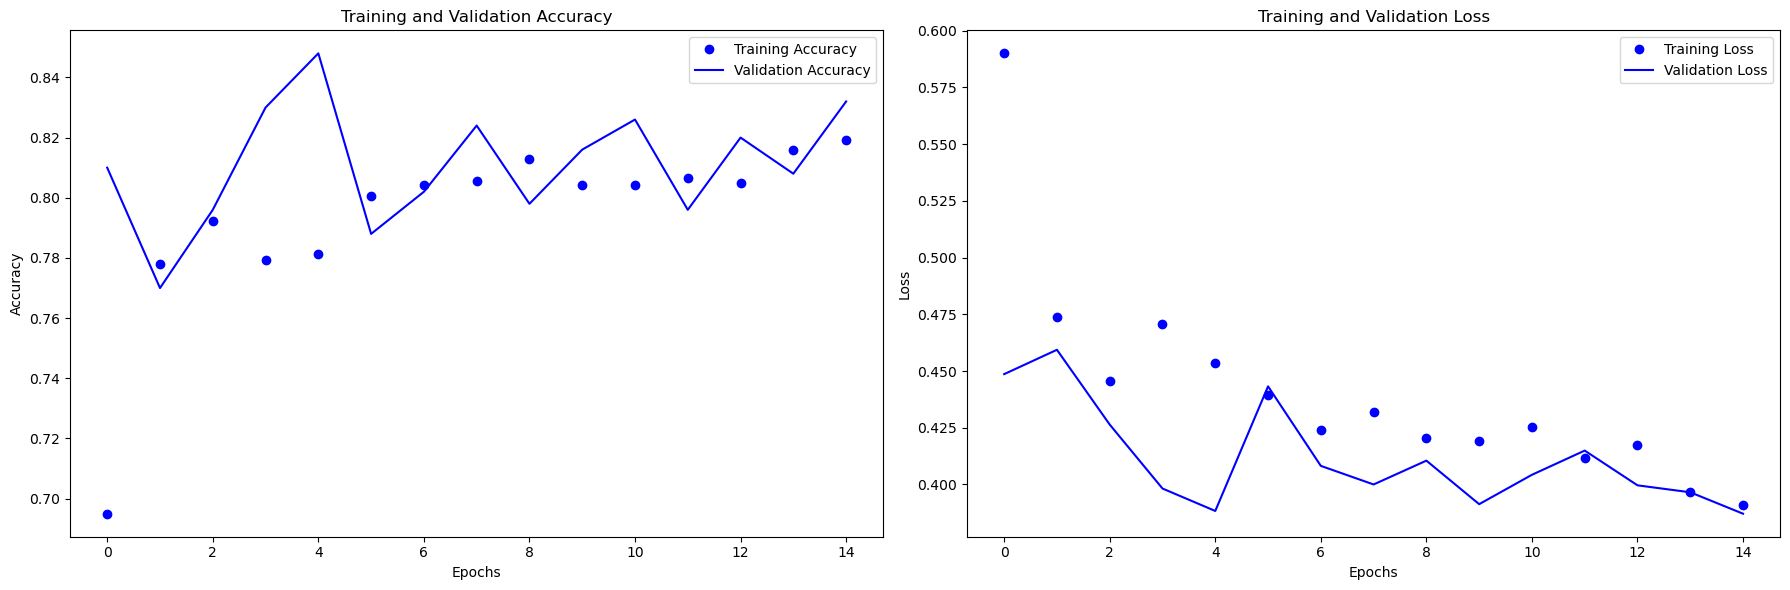

In [72]:
plot_graph(history)

### Test

In [43]:
def confusion_mat(true, pred):
    # Generate confusion matrix
    conf_matrix = confusion_matrix(true, pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [2]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - acc: 0.8033 - loss: 0.4040
Test accuracy: 0.8000
Test loss: 0.3975
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


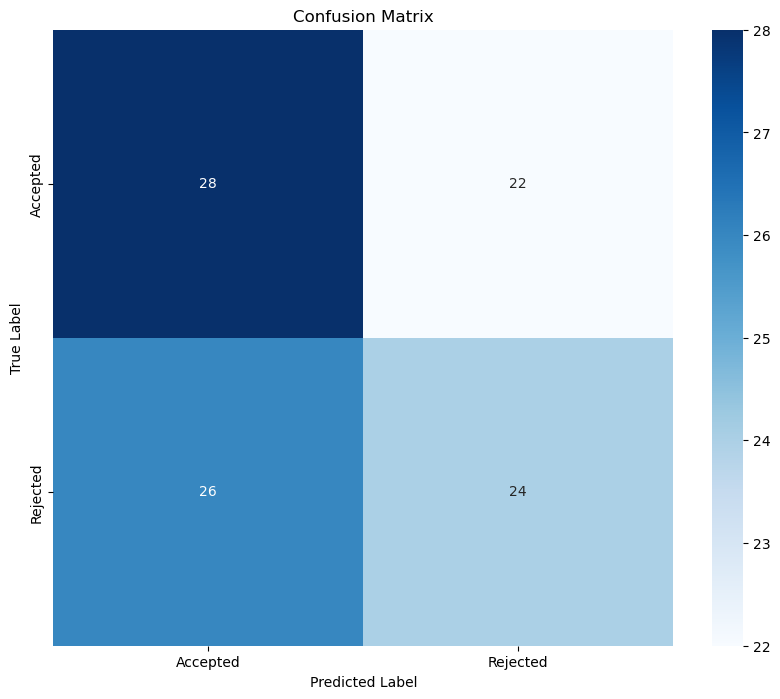

In [53]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model1 = load_model('model1.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model1.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.8082 - loss: 0.4119
Test accuracy: 0.8200
Test loss: 0.3984
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


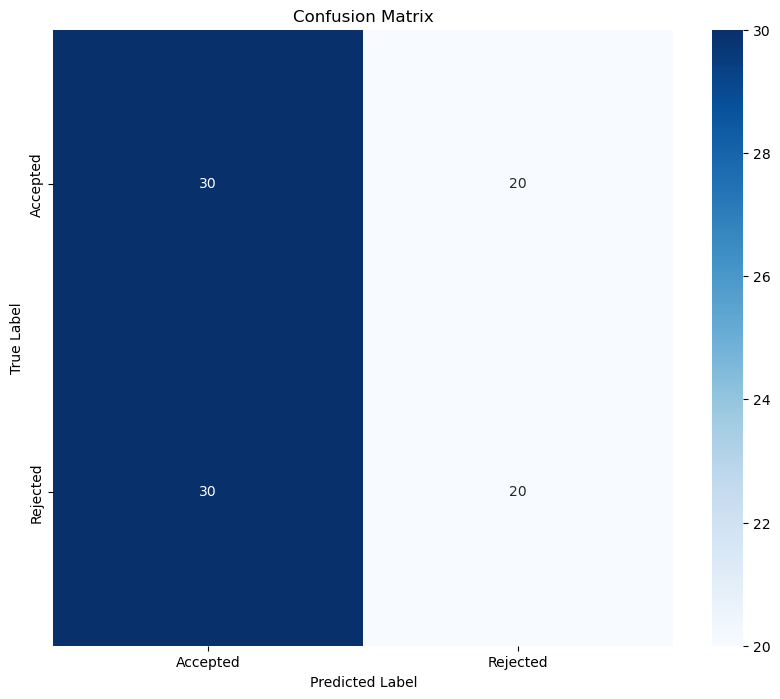

In [74]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model2 = load_model('model2.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model2.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)

In [94]:
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print classification report
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Accepted       0.50      0.60      0.55        50
    Rejected       0.50      0.40      0.44        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.49       100
weighted avg       0.50      0.50      0.49       100



In [4]:
def image_process(img):
    img_size = 150
    image = load_img(img, target_size=(img_size, img_size))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Prediction function
def prediction(model, img_array, items_l):
    prob = model.predict(img_array)
    if prob.shape[1] == 1:
        prob = np.array([[1 - prob[0][0], prob[0][0]]])  # Adjusted for binary classification

    prob_reshaped = prob.reshape(1, -1)

    prob_df = pd.DataFrame(prob_reshaped, columns=items_l)
    result = items_l[np.argmax(prob_reshaped, axis=1)[0]]  # Correctly indexing the list

    return prob_df, result

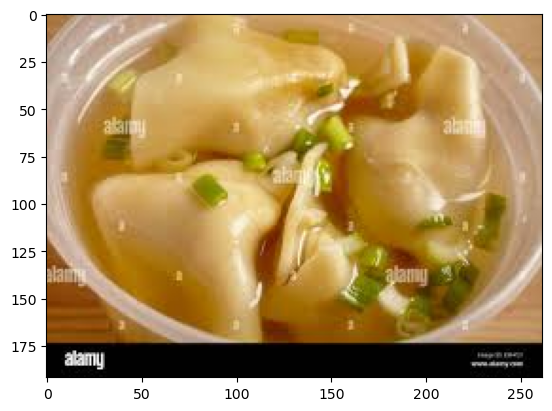

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.076561  0.923439


In [9]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'proid/test1.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

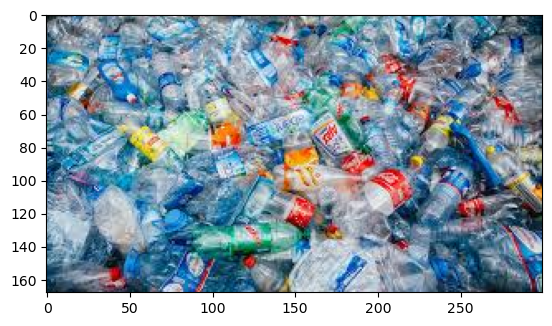

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
The prediction is:  Accepted 

    Accepted  Rejected
0  0.847012  0.152988


In [10]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'proid/test2.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

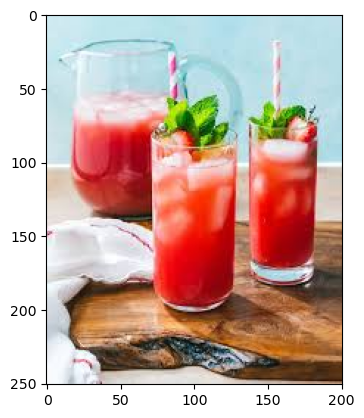

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.415121  0.584879


In [87]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test image.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

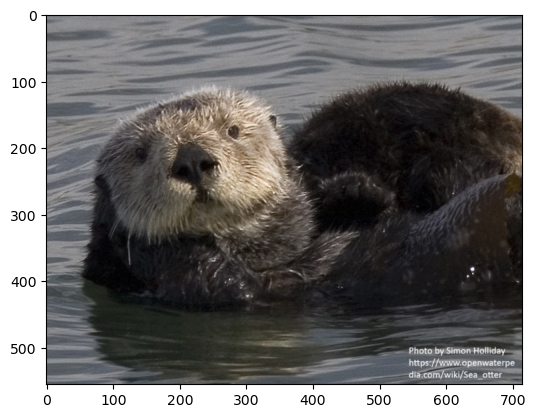

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.357685  0.642315


In [88]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'sea_otter_cropped.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

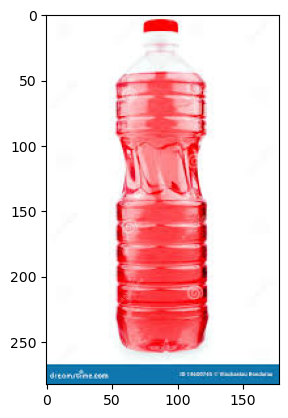

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.377778  0.622222


In [23]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test22.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

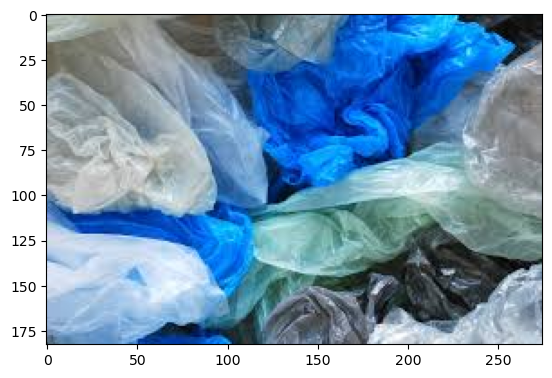

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
The prediction is:  Accepted 

    Accepted  Rejected
0  0.912023  0.087977


In [90]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test23.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

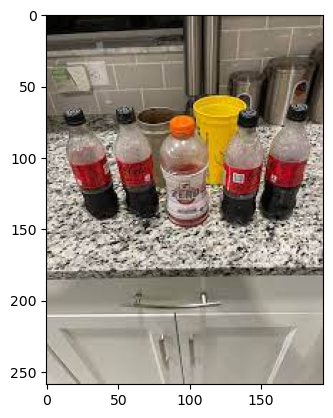

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0   0.33001   0.66999


In [92]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test 24.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

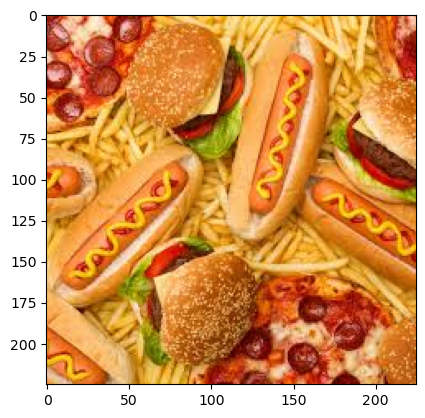

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.054175  0.945825


In [24]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test 30.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

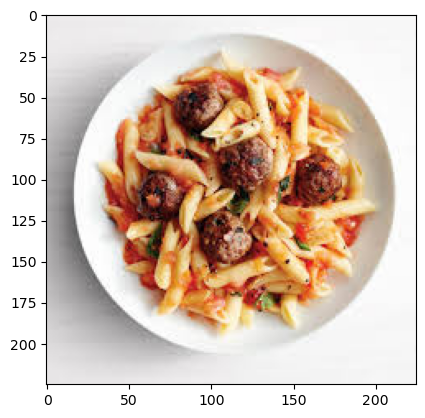

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0   0.06543   0.93457


In [28]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'test 32.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

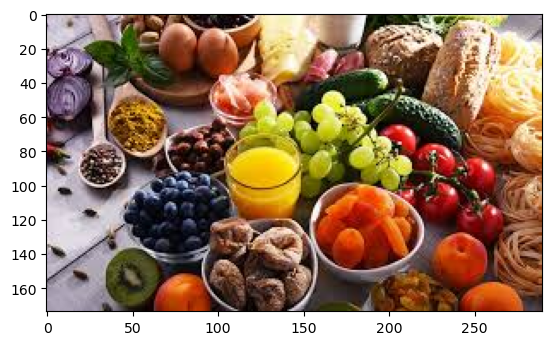

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
The prediction is:  Rejected 

    Accepted  Rejected
0  0.068674  0.931326


In [27]:
model = load_model('model2.keras')

class_list = ['Accepted', 'Rejected']

img = 'food 31.jpg'
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, class_list)
print('The prediction is: ', result, '\n\n', prob_df)

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.8124 - loss: 0.4295
Test accuracy: 0.8200
Test loss: 0.4091
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


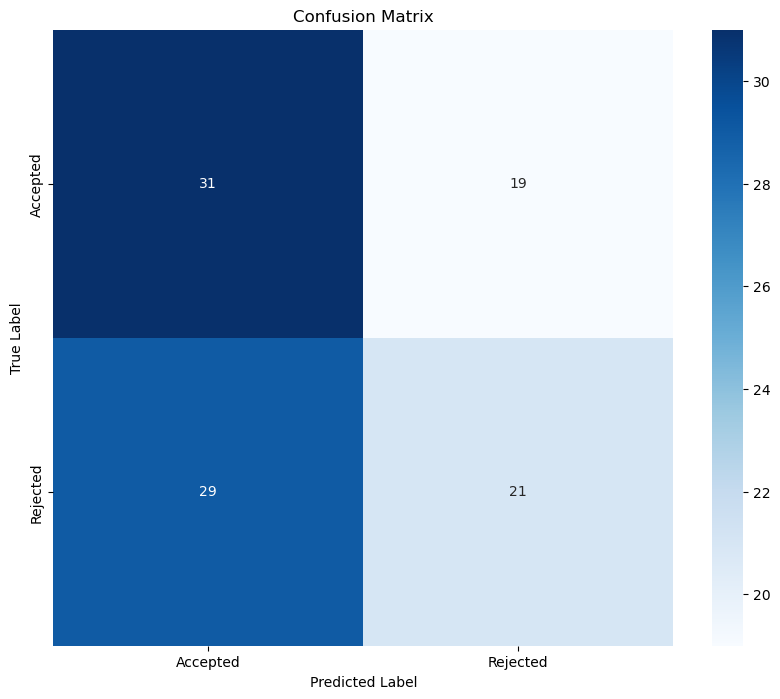

In [86]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model = load_model('model3.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - acc: 0.7561 - loss: 0.7031
Test accuracy: 0.7600
Test loss: 0.6558
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step


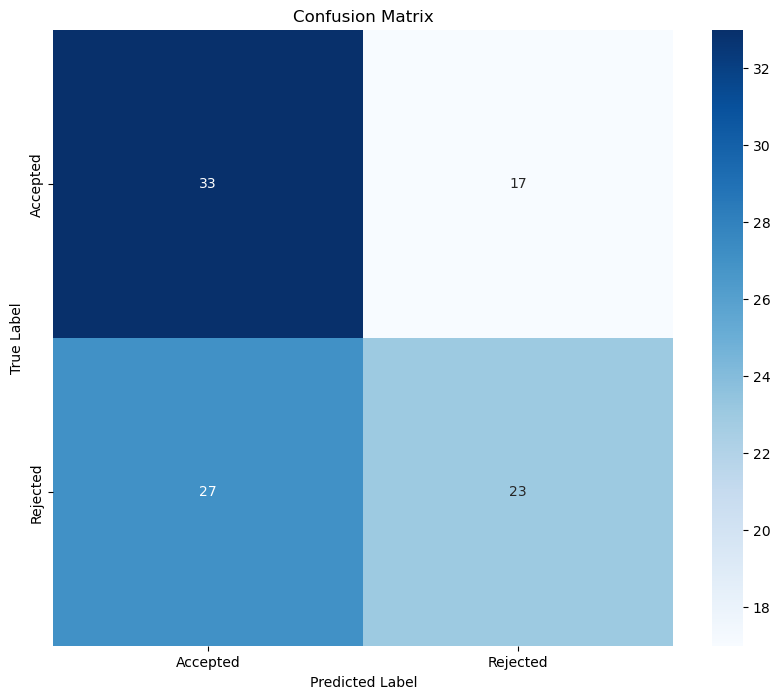

In [64]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model = load_model('pt_model4.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - acc: 0.6770 - loss: 0.5537
Test accuracy: 0.6900
Test loss: 0.5302
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step


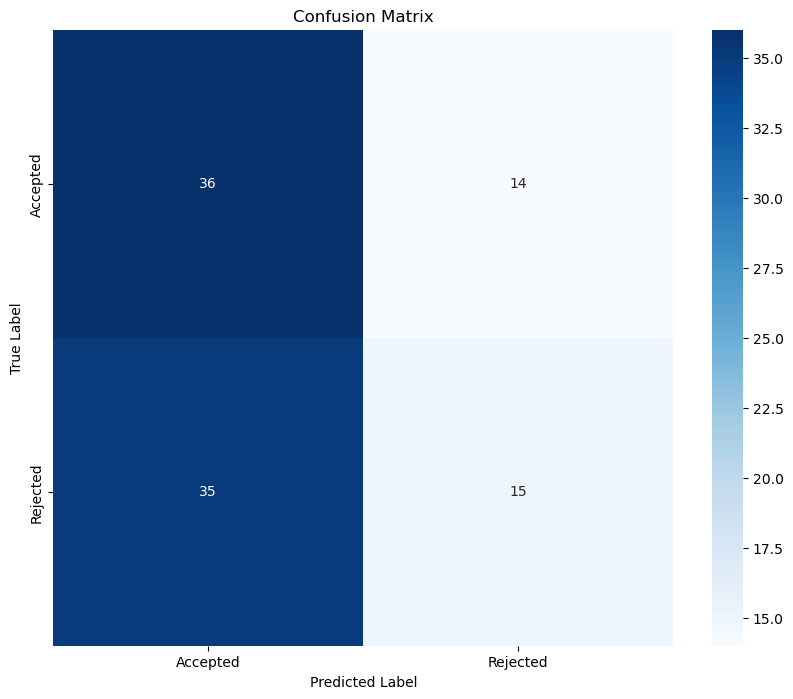

In [70]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model = load_model('pt_model5.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)

Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - acc: 0.7107 - loss: 0.6299
Test accuracy: 0.7300
Test loss: 0.5811
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step


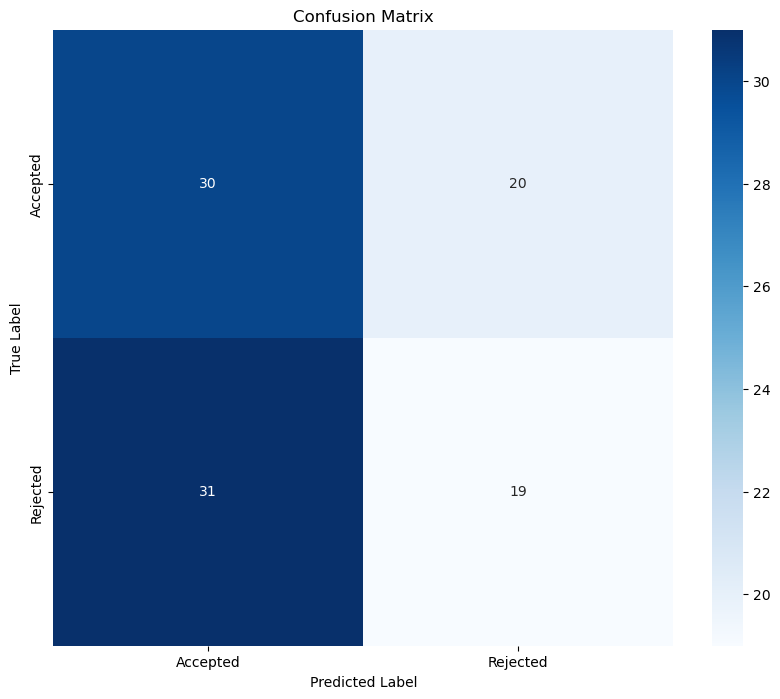

In [73]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


model = load_model('pt_model7.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

y_true = test_generator.classes

# Predict the probabilities for the test data
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

confusion_mat(y_true, y_pred)